## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


## Install

In [4]:
!pip install -q supervision "ultralytics<=8.3.40"
!pip install deep-sort-realtime
!pip install -U supervision
!pip install --force-reinstall --no-cache-dir supervision
!pip install natsort
!pip install torch torchvision torchaudio





Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/38.4 MB ? eta -:--:--
   ---- ----------------------------------- 4.7/38.4 MB 25.9 MB/s eta 0:00:02
   ----------- ---------------------------- 11.0/38.4 MB 28.7 MB/s eta 0:00:01
   ------------------ --------------------- 17.6/38.4 MB 29.2 MB/s eta 0:00:01
   ------------------------- -------------- 24.4/38.4 MB 30.3 MB/s eta 0:00:01
   -------------------------------- ------- 31.5/38.4 MB 30.7 MB/s eta 0:00:01
   ---------------------------------------  37.5/38.4 MB 30.2 MB/s eta 0:00:01
   ---------------------------------------- 38.4/38.4 MB 30.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----------------------------------- ---- 7.1/8.1 MB 33.6 MB/s eta 0:00:0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
label-studio 1.19.0 requires numpy<2.0.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
label-studio 1.19.0 requires urllib3<2.0.0,>=1.26.18, but you have urllib3 2.5.0 which is incompatible.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
roboflow 1.1.66 requires idna==3.7, but you have idna 3.10 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")



PyTorch version: 2.7.1+cpu
CUDA version: None
CUDA available: False
GPU device: No GPU


## Imports

In [3]:
# prevent ultralytics from tracking your activity
!yolo settings sync=False

JSONDict("C:\Users\kavan\AppData\Roaming\Ultralytics\settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "D:\\crowdAcode\\datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "7d8f8e97d734558356af6ea73f665e9203f5ec945ec7471f425762bd10b8a584",
  "sync": false,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


In [2]:
!pip install transformers

import cv2
import os
import torch
import numpy as np
import supervision as sv
import tkinter as tk
from tkinter import filedialog
import networkx as nx
import matplotlib.pyplot as plt
import torchvision.transforms as T
import time
TARGET_FPS = 30
frame_time = 1.0 / TARGET_FPS
last_time = time.time()

from natsort import natsorted
from collections import defaultdict, deque
from tqdm import tqdm
from ultralytics import YOLO
from transformers import DPTImageProcessor, DPTForDepthEstimation
from supervision.assets import VideoAssets, download_assets
from supervision.draw.color import ColorPalette

from collections import defaultdict, deque
from deep_sort_realtime.deepsort_tracker import DeepSort
import math
import sys
sys.path.append("D:\\Internship_Project\\Code_implementation")

tracker = DeepSort(max_age=60)
print("CUDA available:", torch.cuda.is_available())
print("Using device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Defaulting to user installation because normal site-packages is not writeable


CUDA available: False
Using device: cpu


In [3]:
from supervision.draw.color import Color

## Download Data

**NOTE:** In this notebook we will use one of the Supervision Assets videos. [Here](https://supervision.roboflow.com/assets) you can learn more about it.

In [ ]:
root = tk.Tk()
root.withdraw()

# File dialog to select video
file_path = filedialog.askopenfilename(
    title="Select a CCTV video file",
    filetypes=[("MP4 files", "*.mp4"), ("All files", "*.*")]
)

if not file_path or not os.path.exists(file_path):
    raise Exception(f"Could not open video at {file_path}")

print("Selected file:", file_path)

## Configuration

In [ ]:
import os
#PRE-PROCESSING 
INPUT_VIDEO = file_path
PREPROCESSED_VIDEO = os.path.splitext(INPUT_VIDEO)[0] + "_Filtered.mp4"


video_info = sv.VideoInfo.from_video_path(INPUT_VIDEO)
frame_generator = sv.get_video_frames_generator(source_path=INPUT_VIDEO)


fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(PREPROCESSED_VIDEO, fourcc, video_info.fps, video_info.resolution_wh)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


seg_model= YOLO('D:\\Internship_Project\\Code_implementation\\yolo11m-seg.pt').to(device)


to_tensor = T.ToTensor()
to_pil = T.ToPILImage()


def gamma_correction_torch(tensor, gamma=1.1):
    return tensor.pow(gamma)

def sharpen_torch(tensor):
    channels = []
    kernel = torch.tensor([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
    for c in tensor:
        c = c.unsqueeze(0).unsqueeze(0)  
        c = torch.nn.functional.conv2d(c, kernel, padding=1)
        channels.append(c.squeeze(0).squeeze(0))
    return torch.stack(channels)  

def denoise_torch(tensor):
   
    tensor = tensor.unsqueeze(0)  
    tensor = torch.nn.functional.avg_pool2d(tensor, kernel_size=3, stride=1, padding=1)
    return tensor.squeeze(0) 

def apply_filters_torch(frame):
    
    tensor = to_tensor(frame).to(device) 

   
    tensor = gamma_correction_torch(tensor, gamma=1.1)
    tensor = denoise_torch(tensor)
    tensor = sharpen_torch(tensor)

    tensor = torch.clamp(tensor, 0, 1).cpu()

    
    filtered_frame = np.array(to_pil(tensor))
    return filtered_frame


print("🎥 Applying Gaussian blur to background and GPU filters...")
for frame in tqdm(frame_generator, total=video_info.total_frames):
    
    results = seg_model.predict(frame, imgsz=640, conf=0.25, verbose=False)
    person_mask = np.zeros(frame.shape[:2], dtype=np.uint8)

    if results[0].masks is not None:
        for cls, mask in zip(results[0].boxes.cls, results[0].masks.data):
            if int(cls) == 0:  
                resized_mask = cv2.resize(mask.cpu().numpy(), (frame.shape[1], frame.shape[0]))
                person_mask = np.logical_or(person_mask, resized_mask > 0.5)

   
    blurred_frame = cv2.GaussianBlur(frame, (21, 21), sigmaX=0, sigmaY=0)
    mask_3ch = np.repeat(person_mask[:, :, np.newaxis], 3, axis=2)
    combined_frame = np.where(mask_3ch, frame, blurred_frame)

    
    filtered_frame = apply_filters_torch(combined_frame)

    
    out.write(filtered_frame)


out.release()
print("Preprocessing complete. Preprocessed video saved to:", PREPROCESSED_VIDEO)


NameError: name 'sv' is not defined

In [ ]:
VIDEO_PATH = PREPROCESSED_VIDEO
OUTPUT_PATH = os.path.splitext(PREPROCESSED_VIDEO)[0] + "_Skeleton_trained2.mp4"
IOU_THRESHOLD = 0.5
CONFIDENCE_THRESHOLD = 0.3
POSE_CONFIDENCE_THRESHOLD = 0.25
MODEL_RESOLUTION = 1920

In [ ]:
VIDEO_PATH = file_path
OUTPUT_PATH = os.path.splitext(file_path)[0] + "_Skeleton_trained2.mp4"
IOU_THRESHOLD = 0.5
CONFIDENCE_THRESHOLD = 0.3
POSE_CONFIDENCE_THRESHOLD = 0.25
MODEL_RESOLUTION = 1920

In [ ]:
def get_video_resolution(video_path):
   
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video file: {video_path}")
    
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    
    return width, height

def create_source_coordinates(width, height):
   
    return np.array([
        [0, 0],
        [width, 0],
        [width, height],
        [0, height]
    ])

    

In [ ]:
try:
    video_width, video_height = get_video_resolution(VIDEO_PATH)
    print(f"Detected video resolution: {video_width}x{video_height}")
    
    # Create SOURCE coordinates based on detected resolution
    SOURCE = create_source_coordinates(video_width, video_height)
    
    print(f"SOURCE coordinates: {SOURCE}")
    
    # Initialize video processing
    frame_generator = sv.get_video_frames_generator(source_path=VIDEO_PATH)
    frame_iterator = iter(frame_generator)
    frame = next(frame_iterator)
    
    print(f"Ready to process video with resolution: {video_width}x{video_height}")
    
except Exception as e:
    print(f"Error: {e}")
    print("Please check your video file path and ensure the file exists.")

Detected video resolution: 1920x1080
SOURCE coordinates: [[   0    0]
 [1920    0]
 [1920 1080]
 [   0 1080]]
Ready to process video with resolution: 1920x1080


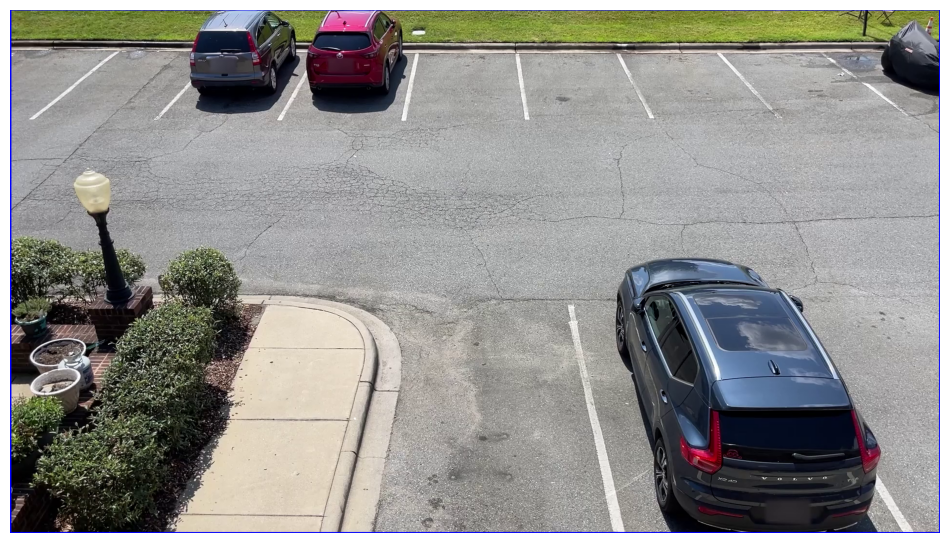

In [ ]:

annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.BLUE, thickness=4)
sv.plot_image(annotated_frame)

## Transform Perspective

In [ ]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

## Process Video

**NOTE:** In this tutorial we use Supervision Annotators. [Here](https://supervision.roboflow.com/annotators) you can learn more about it.

In [ ]:
video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)
print(video_info.fps)

29


In [ ]:

CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5

pose_model = YOLO("yolo11x-pose.pt")
frame_classification_model = YOLO("best.pt")


video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=VIDEO_PATH)


byte_track = sv.ByteTrack(frame_rate=video_info.fps)

width, height = video_info.resolution_wh
thickness = max(1, int(min(width, height) / 500))
text_scale = min(1.0, max(0.3, min(width, height) / 1000))


def euclidean_distance(point1, point2):
    """Calculate euclidean distance between two points"""
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(point1, point2)))



SKELETON_CONNECTIONS = [
    (0, 1), (0, 2), (1, 3), (2, 4),
    (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
    (5, 11), (6, 12), (11, 12),
    (11, 13), (13, 15), (12, 14), (14, 16)
]
BORDER_THICKNESS = 15 
NORMAL_COLOR = (0, 255, 0)    
ABNORMAL_COLOR = (0, 0, 255)  
CONFIDENCE_THRESHOLD_FRAME = 0.5 



UPPER_BODY_KEYPOINTS = [5, 6, 7, 8, 9, 10]
CRITICAL_LIMBS = [7, 8, 9, 10]
ARM_KEYPOINTS = [5, 6, 7, 8, 9, 10]
LEG_KEYPOINTS = [11, 12, 13, 14, 15, 16]

 
POSE_BUFFER_SIZE = 15  
VELOCITY_THRESHOLD = 0.15
VARIANCE_THRESHOLD = 0.12
ACCELERATION_THRESHOLD = 0.18


RUNNING_VELOCITY_THRESHOLD = 0.75      
WALKING_VELOCITY_THRESHOLD = 0.25     
STANDING_VELOCITY_THRESHOLD = 0.08     
RAPID_MOVEMENT_THRESHOLD = 0.55        


MIN_FIGHTING_FRAMES = 10   
MIN_RUNNING_FRAMES = 8     
MIN_WALKING_FRAMES = 10    
MIN_STANDING_FRAMES = 15   



FIGHTING_CONSTANTS = {
    'RAPID_MOVEMENT_THRESHOLD': 0.45,
    'MIN_FIGHTING_FRAMES': 12,
    'FIGHTING_CONFIDENCE_THRESHOLD': 0.68,
    'ARM_BODY_RATIO_THRESHOLD': 2.2,
    'VARIANCE_THRESHOLD': 0.025,
    'EXTREME_MOVEMENT_MULTIPLIER': 1.7,
    'STANCE_SPREAD_THRESHOLD': 1.5,
    'SUSTAINED_ACTIVITY_THRESHOLD': 0.65,
}

class EnhancedPoseAnalyzer:
    def __init__(self, buffer_size=20):
        self.pose_history = defaultdict(lambda: deque(maxlen=buffer_size))
        self.velocity_history = defaultdict(lambda: deque(maxlen=buffer_size-1))
        self.acceleration_history = defaultdict(lambda: deque(maxlen=buffer_size-2))
        self.abnormal_counts = defaultdict(int)
        self.fight_scores = defaultdict(lambda: deque(maxlen=10))
        self.behavior_scores = defaultdict(lambda: {
            'fighting': deque(maxlen=15),
            'running': deque(maxlen=12),
            'fainting': deque(maxlen=5),
            'walking': deque(maxlen=15),
            'standing': deque(maxlen=20)
        })
        self.behavior_counts = defaultdict(lambda: {
            'fighting': 0,
            'running': 0,
            'fainting': 0,
            'walking': 0,
            'standing': 0
        })
        self.position_history = defaultdict(lambda: deque(maxlen=60))
        self.cumulative_distance = defaultdict(float)
        self.frame_dimensions = None
        self.person_sizes = defaultdict(lambda: deque(maxlen=10))
        self.behavior_consistency = defaultdict(lambda: defaultdict(int))
        
        
        self.movement_patterns = defaultdict(lambda: deque(maxlen=12))
        self.direction_changes = defaultdict(int)
        self.body_center_history = defaultdict(lambda: deque(maxlen=10))
        self.limb_coordination = defaultdict(lambda: deque(maxlen=8))

    def set_frame_dimensions(self, width, height):
        """Set frame dimensions for normalization"""
        self.frame_dimensions = (width, height)

    def estimate_person_size(self, keypoints):
        """Improved person size estimation"""
        visible_points = [(x, y) for x, y, conf in keypoints if conf > 0.3]
        if len(visible_points) < 4:
            return 1.0
        
        xs = [p[0] for p in visible_points]
        ys = [p[1] for p in visible_points]
        width = max(xs) - min(xs)
        height = max(ys) - min(ys)
        
        # Better normalization
        if self.frame_dimensions:
            normalized_size = (width * height) / (self.frame_dimensions[0] * self.frame_dimensions[1])
            return max(0.01, min(1.0, normalized_size))
        return 1.0

    def normalize_keypoints(self, keypoints, person_size=1.0):
        """Enhanced keypoint normalization"""
        if self.frame_dimensions is None:
            return keypoints

        normalized = keypoints.copy()
        normalized[:, 0] /= self.frame_dimensions[0]
        normalized[:, 1] /= self.frame_dimensions[1]
        
        return normalized
    
    

    def compute_velocities(self, current_pose, previous_pose, person_size=1.0):
        """Enhanced velocity computation with acceleration consideration"""
        if len(current_pose) != len(previous_pose):
            return np.zeros_like(current_pose)

        velocities = np.zeros_like(current_pose)
        size_factor = 1.0 / max(0.1, person_size)
        
        for i in range(len(current_pose)):
            if current_pose[i][2] > 0.3 and previous_pose[i][2] > 0.3:
                velocities[i][0] = (current_pose[i][0] - previous_pose[i][0]) * size_factor
                velocities[i][1] = (current_pose[i][1] - previous_pose[i][1]) * size_factor
                velocities[i][2] = np.sqrt(velocities[i][0]**2 + velocities[i][1]**2)
        return velocities

    def detect_fighting(self, pose_sequence, velocity_sequence, person_size=1.0):
        """SIGNIFICANTLY IMPROVED: Fighting detection with better arm pattern analysis"""
        if len(velocity_sequence) < 10:
            return False, 0.0

        fight_score = 0.0
        size_factor = 1.0 / max(0.1, person_size)

        recent_velocities = list(velocity_sequence)[-10:]
        recent_poses = list(pose_sequence)[-10:]

        
        arm_velocities = []
        body_velocities = []
        punch_like_movements = 0
        rapid_direction_changes = 0
        
        for i, vel_frame in enumerate(recent_velocities):
            arm_velocity = 0.0
            body_velocity = 0.0
            valid_arms = 0
            valid_body = 0
            
            
            for kp_idx in [5, 6, 7, 8, 9, 10]:
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    arm_velocity += vel_frame[kp_idx][2]
                    valid_arms += 1
                    
                    
                    if vel_frame[kp_idx][2] > RAPID_MOVEMENT_THRESHOLD / size_factor:
                        if i > 0 and kp_idx < len(recent_velocities[i-1]):
                            prev_vel = recent_velocities[i-1][kp_idx][2]
                            if prev_vel < vel_frame[kp_idx][2] * 0.3:  
                                punch_like_movements += 1
            
            
            for kp_idx in [11, 12]:
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    body_velocity += vel_frame[kp_idx][2]
                    valid_body += 1
            
            if valid_arms > 0:
                arm_velocities.append(arm_velocity / valid_arms)
            if valid_body > 0:
                body_velocities.append(body_velocity / valid_body)

        
        if len(arm_velocities) >= 6:
            avg_arm_velocity = np.mean(arm_velocities)
            max_arm_velocity = np.max(arm_velocities)
            arm_variance = np.var(arm_velocities)
            
            
            high_activity_frames = sum(1 for v in arm_velocities if v > RAPID_MOVEMENT_THRESHOLD * 0.7 / size_factor)
            if high_activity_frames >= 5:
                fight_score += 0.3
                
                
                if arm_variance > 0.02:
                    fight_score += 0.2
            
            
            if punch_like_movements >= 2.5:
                fight_score += 0.25
            
            
            if len(body_velocities) >= 6:
                avg_body_velocity = np.mean(body_velocities)
                if avg_body_velocity > 0.001:
                    ratio = avg_arm_velocity / avg_body_velocity
                    if ratio > 2.0:  # Arms moving much more than body
                        fight_score += 0.2
                    
                    # Penalize if body is moving too much (likely running/walking)
                    if avg_body_velocity > 0.2:
                        fight_score *= 0.4
            
            # Pattern 4: Rapid direction changes in arm movements
            for i in range(1, len(arm_velocities)):
                if abs(arm_velocities[i] - arm_velocities[i-1]) > 0.15:
                    rapid_direction_changes += 1
            
            if rapid_direction_changes >= 4:
                fight_score += 0.15

        # 3. BODY POSITION ANALYSIS (Fighting stance detection)
        stance_scores = []
        for pose in recent_poses[-5:]:
            if len(pose) >= 17:
                # Check for fighting stance (wide leg spread, arms positioned)
                left_shoulder = pose[5]
                right_shoulder = pose[6]
                left_hip = pose[11]
                right_hip = pose[12]
                
                if all(kp[2] > 0.3 for kp in [left_shoulder, right_shoulder, left_hip, right_hip]):
                    shoulder_width = abs(left_shoulder[0] - right_shoulder[0])
                    hip_width = abs(left_hip[0] - right_hip[0])
                    
                    if shoulder_width > hip_width * 1.2:  # Shoulders wider than hips
                        stance_scores.append(1.0)
                    else:
                        stance_scores.append(0.0)
        
        if len(stance_scores) >= 3 and np.mean(stance_scores) > 0.6:
            fight_score += 0.1

        # 4. FINAL THRESHOLD AND PENALTIES
        # Penalize excessive body movement (indicates running/walking)
        if len(body_velocities) >= 6:
            total_body_movement = np.sum(body_velocities)
            if total_body_movement > 1.5:
                fight_score *= 0.3
            elif total_body_movement > 1.0:
                fight_score *= 0.6

        min_confidence = 0.70
        is_fighting = fight_score > min_confidence

        return is_fighting, min(fight_score, 1.0)

    def detect_running(self, pose_sequence, velocity_sequence, person_size=1.0):
        """SIGNIFICANTLY IMPROVED: Running detection with better coordination analysis"""
        if len(velocity_sequence) < 8:
            return False, 0.0

        running_score = 0.0
        size_factor = 1.0 / max(0.1, person_size)
        
        recent_velocities = list(velocity_sequence)[-8:]
        recent_poses = list(pose_sequence)[-8:]
        
        
        total_movements = []
        leg_movements = []
        arm_movements = []
        body_center_movements = []
        
        for i, vel_frame in enumerate(recent_velocities):
            total_movement = 0.0
            leg_movement = 0.0
            arm_movement = 0.0
            valid_total = 0
            valid_legs = 0
            valid_arms = 0
            
            
            for kp_idx in range(len(vel_frame)):
                if vel_frame[kp_idx][2] > 0:
                    total_movement += vel_frame[kp_idx][2]
                    valid_total += 1
            
            
            for kp_idx in [11, 12, 13, 14, 15, 16]:
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    leg_movement += vel_frame[kp_idx][2]
                    valid_legs += 1
            
            
            for kp_idx in [5, 6, 7, 8, 9, 10]:
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    arm_movement += vel_frame[kp_idx][2]
                    valid_arms += 1
            
            if valid_total > 0:
                total_movements.append(total_movement / valid_total)
            if valid_legs > 0:
                leg_movements.append(leg_movement / valid_legs)
            if valid_arms > 0:
                arm_movements.append(arm_movement / valid_arms)
            
            
            if i < len(recent_poses):
                pose = recent_poses[i]
                if len(pose) >= 13:
                    left_hip = pose[11]
                    right_hip = pose[12]
                    if left_hip[2] > 0.3 and right_hip[2] > 0.3:
                        center_x = (left_hip[0] + right_hip[0]) / 2
                        center_y = (left_hip[1] + right_hip[1]) / 2
                        if i > 0 and body_center_movements:
                            prev_center = body_center_movements[-1]
                            movement = np.sqrt((center_x - prev_center[0])**2 + (center_y - prev_center[1])**2)
                            body_center_movements.append((center_x, center_y, movement))
                        else:
                            body_center_movements.append((center_x, center_y, 0))

         
        if len(total_movements) >= 6:
            avg_total_movement = np.mean(total_movements)
            adjusted_threshold = RUNNING_VELOCITY_THRESHOLD / size_factor
            
            
            high_movement_frames = sum(1 for m in total_movements if m > adjusted_threshold)
            if high_movement_frames >= 5:
                running_score += 0.35
            elif high_movement_frames >= 4:
                running_score += 0.2
            
             
            if avg_total_movement > adjusted_threshold * 1.1:
                running_score += 0.25
            
            
            if len(leg_movements) >= 6:
                avg_leg_movement = np.mean(leg_movements)
                leg_consistency = 1.0 - np.var(leg_movements) / (np.mean(leg_movements) + 0.001)
                
                if avg_leg_movement > adjusted_threshold * 0.8:
                    running_score += 0.2
                if leg_consistency > 0.7:
                    running_score += 0.1
            
            
            if len(arm_movements) >= 6:
                avg_arm_movement = np.mean(arm_movements)
                arm_consistency = 1.0 - np.var(arm_movements) / (np.mean(arm_movements) + 0.001)
                
                
                if 0.3 < avg_arm_movement < 0.7 and arm_consistency > 0.6:
                    running_score += 0.15
                elif avg_arm_movement > 0.8:  
                    running_score *= 0.5
            
            
            if len(body_center_movements) >= 5:
                total_progression = sum(movement for _, _, movement in body_center_movements[1:])
                if total_progression > 0.3:  
                    running_score += 0.1

      
        movement_variance = np.var(total_movements) if total_movements else 0
        if movement_variance > 0.08:  
            running_score *= 0.6

       
        min_confidence = 0.75
        is_running = running_score > min_confidence

        return is_running, min(running_score, 1.0)

    def detect_walking(self, velocity_sequence, person_size=1.0):
        """IMPROVED: Walking detection with better range and consistency"""
        if len(velocity_sequence) < 8:
            return False, 0.0

        walking_score = 0.0
        size_factor = 1.0 / max(0.1, person_size)
        
        recent_velocities = list(velocity_sequence)[-8:]
        
        total_movements = []
        leg_movements = []
        
        for vel_frame in recent_velocities:
            total_movement = 0.0
            leg_movement = 0.0
            valid_total = 0
            valid_legs = 0
            
            
            for kp_idx in range(len(vel_frame)):
                if vel_frame[kp_idx][2] > 0:
                    total_movement += vel_frame[kp_idx][2]
                    valid_total += 1
            
            
            for kp_idx in [11, 12, 13, 14, 15, 16]:
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    leg_movement += vel_frame[kp_idx][2]
                    valid_legs += 1
            
            if valid_total > 0:
                total_movements.append(total_movement / valid_total)
            if valid_legs > 0:
                leg_movements.append(leg_movement / valid_legs)
        
        if len(total_movements) >= 6:
            avg_total_movement = np.mean(total_movements)
            adjusted_walking_min = WALKING_VELOCITY_THRESHOLD / size_factor
            adjusted_walking_max = RUNNING_VELOCITY_THRESHOLD / size_factor
            
            
            if adjusted_walking_min < avg_total_movement < adjusted_walking_max:
                walking_score += 0.4
                
               
                movement_variance = np.var(total_movements)
                if movement_variance < 0.015:  
                    walking_score += 0.3
                elif movement_variance < 0.025:  
                    walking_score += 0.2
                
                
                if len(leg_movements) >= 6:
                    avg_leg_movement = np.mean(leg_movements)
                    if adjusted_walking_min * 0.8 < avg_leg_movement < adjusted_walking_max * 0.9:
                        walking_score += 0.2
                
                
                moderate_movement_frames = sum(1 for m in total_movements 
                                            if adjusted_walking_min < m < adjusted_walking_max)
                if moderate_movement_frames >= 6:
                    walking_score += 0.1

        return walking_score > 0.7, walking_score

    def detect_standing(self, velocity_sequence, person_size=1.0):
        """IMPROVED: Standing detection with better stability analysis"""
        if len(velocity_sequence) < 8:
            return False, 0.0

        standing_score = 0.0
        size_factor = 1.0 / max(0.1, person_size)
        
        recent_velocities = list(velocity_sequence)[-8:]
        
        total_movements = []
        stability_scores = []
        
        for vel_frame in recent_velocities:
            total_movement = 0.0
            valid_total = 0
            
            
            for kp_idx in range(len(vel_frame)):
                if vel_frame[kp_idx][2] > 0:
                    total_movement += vel_frame[kp_idx][2]
                    valid_total += 1
            
            if valid_total > 0:
                avg_movement = total_movement / valid_total
                total_movements.append(avg_movement)
                
                
                adjusted_threshold = STANDING_VELOCITY_THRESHOLD / size_factor
                if avg_movement < adjusted_threshold:
                    stability_scores.append(1.0)
                elif avg_movement < adjusted_threshold * 1.5:
                    stability_scores.append(0.5)
                else:
                    stability_scores.append(0.0)
        
        if len(total_movements) >= 6:
            avg_total_movement = np.mean(total_movements)
            adjusted_threshold = STANDING_VELOCITY_THRESHOLD / size_factor
            
            
            if avg_total_movement < adjusted_threshold:
                standing_score += 0.5
                
                
                movement_variance = np.var(total_movements)
                if movement_variance < 0.005:  
                    standing_score += 0.3
                elif movement_variance < 0.01:  
                    standing_score += 0.2
                
               
                stable_frames = sum(stability_scores)
                if stable_frames >= 6:
                    standing_score += 0.2
                elif stable_frames >= 4:
                    standing_score += 0.1

        return standing_score > 0.8, standing_score

    def analyze_pose(self, track_id, keypoints):
        """ENHANCED: Main analysis with improved behavior differentiation"""
        if keypoints is None or len(keypoints) < 17:
            return "normal", 0.0

        person_size = self.estimate_person_size(keypoints)
        self.person_sizes[track_id].append(person_size)
        avg_person_size = np.mean(list(self.person_sizes[track_id]))

        normalized_keypoints = self.normalize_keypoints(keypoints, avg_person_size)
        self.pose_history[track_id].append(normalized_keypoints)

        if len(self.pose_history[track_id]) < 10:
            return "normal", 0.0

        # Compute velocities
        current_pose = self.pose_history[track_id][-1]
        previous_pose = self.pose_history[track_id][-2]
        velocities = self.compute_velocities(current_pose, previous_pose, avg_person_size)
        self.velocity_history[track_id].append(velocities)

        # Detect behaviors with improved methods
        behaviors = {}
        
        # Fighting detection
        is_fighting, fight_score = self.detect_fighting(
            list(self.pose_history[track_id]), 
            list(self.velocity_history[track_id]),
            avg_person_size
        )
        behaviors['fighting'] = (is_fighting, fight_score)
        self.behavior_scores[track_id]['fighting'].append(fight_score)
        
        # Running detection
        is_running, run_score = self.detect_running(
            list(self.pose_history[track_id]), 
            list(self.velocity_history[track_id]),
            avg_person_size
        )
        behaviors['running'] = (is_running, run_score)
        self.behavior_scores[track_id]['running'].append(run_score)
        
        # Walking detection
        is_walking, walk_score = self.detect_walking(
            list(self.velocity_history[track_id]),
            avg_person_size
        )
        behaviors['walking'] = (is_walking, walk_score)
        self.behavior_scores[track_id]['walking'].append(walk_score)
        
        # Standing detection
        is_standing, stand_score = self.detect_standing(
            list(self.velocity_history[track_id]),
            avg_person_size
        )
        behaviors['standing'] = (is_standing, stand_score)
        self.behavior_scores[track_id]['standing'].append(stand_score)

        # Update behavior counts with improved logic
        for behavior_name, (is_detected, score) in behaviors.items():
            if is_detected:
                self.behavior_counts[track_id][behavior_name] += 1
            else:
                # Gradual decay
                self.behavior_counts[track_id][behavior_name] = max(0, 
                    self.behavior_counts[track_id][behavior_name] - 1)

        # Enhanced behavior priority system
        primary_behavior = "normal"
        max_score = 0.0
        
        # Priority order: Fighting > Running > Walking > Standing
        if self.behavior_counts[track_id]['fighting'] >= MIN_FIGHTING_FRAMES:
            primary_behavior = "fighting"
            max_score = behaviors['fighting'][1]
        elif self.behavior_counts[track_id]['running'] >= MIN_RUNNING_FRAMES:
            # Additional check to prevent false running detection
            recent_fight_scores = list(self.behavior_scores[track_id]['fighting'])[-5:]
            avg_fight_score = np.mean(recent_fight_scores) if recent_fight_scores else 0
            if avg_fight_score < 0.3:  # Low fighting score
                primary_behavior = "running"
                max_score = behaviors['running'][1]
        elif self.behavior_counts[track_id]['walking'] >= MIN_WALKING_FRAMES:
            primary_behavior = "walking"
            max_score = behaviors['walking'][1]
        elif self.behavior_counts[track_id]['standing'] >= MIN_STANDING_FRAMES:
            primary_behavior = "standing"
            max_score = behaviors['standing'][1]

        return primary_behavior, max_score

BEHAVIOR_COLORS = {
    'fighting': (0, 0, 255),        # RED
    'running': (255, 0, 0),         # BLUE  
    'fainting': (255, 0, 255),      # MAGENTA
    'walking': (0, 255, 0),         # GREEN
    'standing': (0, 255, 255),      # YELLOW
    'normal': (128, 128, 128)       # GRAY
}
def draw_frame_border(frame, is_abnormal, confidence=0.0, anomaly_rate=0.0):
       
        height, width = frame.shape[:2]
        
        # Choose color based on abnormality
        border_color = ABNORMAL_COLOR if is_abnormal else NORMAL_COLOR
        
        # Draw the border (top, bottom, left, right)
        # Top border
        cv2.rectangle(frame, (0, 0), (width, BORDER_THICKNESS), border_color, -1)
        # Bottom border
        cv2.rectangle(frame, (0, height - BORDER_THICKNESS), (width, height), border_color, -1)
        # Left border
        cv2.rectangle(frame, (0, 0), (BORDER_THICKNESS, height), border_color, -1)
        # Right border
        cv2.rectangle(frame, (width - BORDER_THICKNESS, 0), (width, height), border_color, -1)
        
        # Add status text in top-right corner
        status_text = "ABNORMAL" if is_abnormal else "NORMAL"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        font_thickness = 2
        
        # Calculate text size for positioning
        (text_width, text_height), baseline = cv2.getTextSize(status_text, font, font_scale, font_thickness)
        
        # Position text in top-right corner with some padding
        text_x = width - text_width - 30
        text_y = 40
        
        # Draw background rectangle for text
        cv2.rectangle(frame, (text_x - 10, text_y - text_height - 10), 
                    (text_x + text_width + 10, text_y + 10), border_color, -1)
        
        # Draw text
        cv2.putText(frame, status_text, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)
        
        # Add confidence score if available
        if confidence > 0:
            conf_text = f"Conf: {confidence:.2f}"
            cv2.putText(frame, conf_text, (text_x, text_y + 25), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        # Add anomaly rate if available
        if anomaly_rate > 0:
            rate_text = f"Anomaly Rate: {anomaly_rate:.1f}%"
            cv2.putText(frame, rate_text, (30, height - 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        return frame
def classify_frame_behavior(frame, model):
    
    try:
        # Run inference on the entire frame
        results = model(frame, imgsz=640, conf=0.3, verbose=False)
        
        if not results or len(results) == 0:
            return False, 0.0
        
        result = results[0]
        
        # Check if any abnormal behavior is detected
        if hasattr(result, 'boxes') and result.boxes is not None:
            boxes = result.boxes
            if len(boxes) > 0:
                # Get the highest confidence detection
                confidences = boxes.conf.cpu().numpy()
                classes = boxes.cls.cpu().numpy()
                
                # Print debug info (remove after testing)
                print(f"Detected classes: {classes}, Confidences: {confidences}")
                
                # Check if we have any detections above threshold
                high_conf_detections = confidences > CONFIDENCE_THRESHOLD_FRAME
                
                if np.any(high_conf_detections):
                    high_conf_classes = classes[high_conf_detections]
                    high_conf_scores = confidences[high_conf_detections]
                    
                    # Get the highest confidence detection
                    max_idx = np.argmax(high_conf_scores)
                    detected_class = high_conf_classes[max_idx]
                    max_confidence = high_conf_scores[max_idx]
                    
                    # Determine if abnormal based on class
                    # You may need to adjust these class numbers based on your model
                    # Common scenarios:
                    # - If your model has classes like: 0=normal, 1=fighting, 2=violence, etc.
                    # - Or if it's binary: 0=normal, 1=abnormal
                    # - Or if it's the opposite: 0=abnormal, 1=normal
                    
                    # ADJUST THIS BASED ON YOUR MODEL'S CLASS MAPPING:
                    abnormal_classes = [0]  # Adjust these numbers based on your model
                    # If you have a binary classifier, use: abnormal_classes = [1]
                    # If normal=1 and abnormal=0, use: abnormal_classes = [0]
                    
                    is_abnormal = detected_class in abnormal_classes
                    return is_abnormal, max_confidence
                else:
                    # No high confidence detections
                    return False, 0.0
        
        # No boxes detected - consider as normal
        return False, 0.0
        
    except Exception as e:
        print(f"Error in frame classification: {e}")
        return False, 0.0

# Custom function to draw behavior-specific labels
def draw_behavior_labels(frame, detections, pose_analyzer):
    """Draw labels with behavior-specific colors"""
    if len(detections) == 0:
        return frame
    
    for i, track_id in enumerate(detections.tracker_id):
        # Get the current behavior for this person
        max_behavior = "normal"
        max_count = 0
        
        for behavior_name, count in pose_analyzer.behavior_counts[track_id].items():
            if count >= 3 and count > max_count:
                max_count = count
                max_behavior = behavior_name
        
        # Get bounding box coordinates
        x1, y1, x2, y2 = detections.xyxy[i].astype(int)
        
        # Create label text
        if max_behavior != "normal":
            # Get latest score for the detected behavior
            latest_scores = pose_analyzer.behavior_scores[track_id][max_behavior]
            latest_score = list(latest_scores)[-1] if latest_scores else 0
            label_text = f"Person #{track_id} - {max_behavior.upper()}! ({latest_score:.2f})"
        else:
            label_text = f"Person #{track_id} - Normal"
        
        # Get behavior-specific color
        color = BEHAVIOR_COLORS.get(max_behavior, BEHAVIOR_COLORS['normal'])
        
        # Calculate text size
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        font_thickness = 2
        (text_width, text_height), baseline = cv2.getTextSize(label_text, font, font_scale, font_thickness)
        
        # Draw background rectangle for label
        label_bg_color = color
        cv2.rectangle(frame, (x1, y1 - text_height - 10), (x1 + text_width + 10, y1), label_bg_color, -1)
        
        # Draw text
        text_color = (255, 255, 255)  # White text
        cv2.putText(frame, label_text, (x1 + 5, y1 - 5), font, font_scale, text_color, font_thickness)
    
    return frame

# Also update the draw_enhanced_skeleton function to use the same color mapping
def draw_enhanced_skeleton(frame, keypoints, behavior, confidence=0.0):
    """Enhanced skeleton drawing with behavior-specific colors"""
    if keypoints is None or len(keypoints) < 17:
        return frame

    # Use the same color mapping as labels
    color = BEHAVIOR_COLORS.get(behavior, BEHAVIOR_COLORS['normal'])
    thickness = 3 if behavior in ['fighting', 'running', 'fainting'] else 2

    # Draw keypoints
    for i, (x, y, conf) in enumerate(keypoints):
        if conf > 0.3:
            cv2.circle(frame, (int(x), int(y)), 5, color, -1)
            cv2.circle(frame, (int(x), int(y)), 7, (255, 255, 255), 1)

    # Draw skeleton connections
    for pt1_idx, pt2_idx in SKELETON_CONNECTIONS:
        if pt1_idx < len(keypoints) and pt2_idx < len(keypoints):
            x1, y1, conf1 = keypoints[pt1_idx]
            x2, y2, conf2 = keypoints[pt2_idx]
            if conf1 > 0.3 and conf2 > 0.3:
                cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

    return frame


pose_analyzer = EnhancedPoseAnalyzer(buffer_size=POSE_BUFFER_SIZE)
pose_analyzer.set_frame_dimensions(width, height)



fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, video_info.fps, (width, height))

frame_count = 0
abnormal_frame_count = 0
total_processed_frames = 0
successful_frames = 0 
anomaly_rate_history = deque(maxlen=100)




# Add this BEFORE your main processing loop starts
print("Processing video frames...")


try:
    for frame in frame_generator:
        frame_count += 1
        total_processed_frames += 1
        
        try:
            # Your existing processing code (keep everything the same)
            results = pose_model(frame, imgsz=640, conf=0.25, verbose=False)
            if not results:
                out.write(frame)
                continue

            result = results[0]
            detections = sv.Detections.from_ultralytics(result)
            if len(detections) > 0:
                detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
                detections = detections.with_nms(IOU_THRESHOLD)
                detections = byte_track.update_with_detections(detections=detections)

            is_frame_abnormal, frame_confidence = classify_frame_behavior(frame, frame_classification_model)
            
            if is_frame_abnormal:
                abnormal_frame_count += 1
            
            current_anomaly_rate = (abnormal_frame_count / total_processed_frames) * 100
            anomaly_rate_history.append(current_anomaly_rate)
            
            annotated_frame = frame.copy()
            if hasattr(result, 'keypoints') and result.keypoints is not None:
                keypoints_data = result.keypoints.data.cpu().numpy()
                for i, keypoints in enumerate(keypoints_data):
                    if i < len(detections):
                        track_id = detections.tracker_id[i] if detections.tracker_id is not None else i
                        behavior, confidence = pose_analyzer.analyze_pose(track_id, keypoints)
                        annotated_frame = draw_enhanced_skeleton(annotated_frame, keypoints, behavior, confidence)

            if len(detections) > 0:
                labels = []
                for i, track_id in enumerate(detections.tracker_id):
                    max_behavior = "normal"
                    max_count = 0
                    
                    for behavior_name, count in pose_analyzer.behavior_counts[track_id].items():
                        if count >= 3 and count > max_count:
                            max_count = count
                            max_behavior = behavior_name
                    
                    if max_behavior != "normal":
                        latest_scores = pose_analyzer.behavior_scores[track_id][max_behavior]
                        latest_score = list(latest_scores)[-1] if latest_scores else 0
                        labels.append(f"Person #{track_id} - {max_behavior.upper()}! ({latest_score:.2f})")
                    else:
                        labels.append(f"Person #{track_id} - Normal")

                annotated_frame = draw_behavior_labels(annotated_frame, detections, pose_analyzer)

            annotated_frame = draw_frame_border(
                annotated_frame, 
                is_frame_abnormal, 
                frame_confidence, 
                current_anomaly_rate
            )

            out.write(annotated_frame)
            successful_frames += 1

        except Exception as frame_error:
            # Remove this print statement: print(f"Error processing frame {frame_count}: {frame_error}")
            out.write(frame)
            continue

        

except Exception as e:
    print(f"Critical error: {e}")
finally:
    out.release()
    cv2.destroyAllWindows()
    
    # Only print completion message at the very end
    print("Processing complete.")



Processing video frames...
Detected classes: [          1], Confidences: [    0.40166]
Detected classes: [          1           0], Confidences: [    0.44337     0.42366]
Detected classes: [          0           1], Confidences: [    0.51229      0.3952]
Detected classes: [          1], Confidences: [    0.72534]
Detected classes: [          1], Confidences: [    0.48886]
Detected classes: [          1], Confidences: [    0.66162]
Detected classes: [          1           0], Confidences: [    0.48013     0.42117]
Detected classes: [          0], Confidences: [    0.60242]
Detected classes: [          0], Confidences: [    0.69146]
Detected classes: [          0], Confidences: [    0.70967]
Detected classes: [          0], Confidences: [    0.71958]
Detected classes: [          0], Confidences: [    0.73475]
Detected classes: [          0], Confidences: [    0.74212]
Detected classes: [          0           0], Confidences: [    0.70844     0.34757]
Detected classes: [          0       

In [ ]:

CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
diffrentiatiom_model = YOLO("D:\\Internship_Project\\mall_dataset\\runs_ucf\\train8\\weights\\best.pt")
pose_model = YOLO("D:\\Internship_Project\\yolo11x-pose.pt")

video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=VIDEO_PATH)


byte_track = sv.ByteTrack(frame_rate=video_info.fps)

width, height = video_info.resolution_wh
thickness = max(1, int(min(width, height) / 500))
text_scale = min(1.0, max(0.3, min(width, height) / 1000))

# Define euclidean distance function
def euclidean_distance(point1, point2):
    """Calculate euclidean distance between two points"""
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(point1, point2)))



SKELETON_CONNECTIONS = [
    (0, 1), (0, 2), (1, 3), (2, 4),
    (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
    (5, 11), (6, 12), (11, 12),
    (11, 13), (13, 15), (12, 14), (14, 16)
]

# Enhanced pose analysis constants
POSE_BUFFER_SIZE = 15
VELOCITY_THRESHOLD = 0.20
VARIANCE_THRESHOLD = 0.15
ACCELERATION_THRESHOLD = 0.2
RAPID_MOVEMENT_THRESHOLD = 0.30

# Define body parts for targeted analysis
UPPER_BODY_KEYPOINTS = [5, 6, 7, 8, 9, 10]
CRITICAL_LIMBS = [7, 8, 9, 10]
ARM_KEYPOINTS = [5, 6, 7, 8, 9, 10]
LEG_KEYPOINTS = [11, 12, 13, 14, 15, 16]


RUNNING_VELOCITY_THRESHOLD = 0.85     
FAINTING_THRESHOLD = 0.8
WALKING_VELOCITY_THRESHOLD = 0.15     
STANDING_VELOCITY_THRESHOLD = 0.06    
RAPID_MOVEMENT_THRESHOLD = 0.65       


MIN_FIGHTING_FRAMES = 10  # Moderate requirement
MIN_RUNNING_FRAMES = 10   # Keep original
MIN_WALKING_FRAMES = 8    # Keep lower for walking
MIN_STANDING_FRAMES = 12  # Keep lower for standing


FIGHTING_CONSTANTS = {
    'RAPID_MOVEMENT_THRESHOLD': 0.45,        
    'MIN_FIGHTING_FRAMES': 10,               
    'FIGHTING_CONFIDENCE_THRESHOLD': 0.7,    
    'ARM_BODY_RATIO_THRESHOLD': 2.5,         
    'VARIANCE_THRESHOLD': 0.025,             
    'EXTREME_MOVEMENT_MULTIPLIER': 1.8,      
    'STANCE_SPREAD_THRESHOLD': 1.6,          
    'SUSTAINED_ACTIVITY_THRESHOLD': 0.65,    
}

class EnhancedPoseAnalyzer:
    def __init__(self, buffer_size=20):  # Increased buffer size
        self.pose_history = defaultdict(lambda: deque(maxlen=buffer_size))
        self.velocity_history = defaultdict(lambda: deque(maxlen=buffer_size-1))
        self.acceleration_history = defaultdict(lambda: deque(maxlen=buffer_size-2))
        self.abnormal_counts = defaultdict(int)
        self.fight_scores = defaultdict(lambda: deque(maxlen=8))  # Increased
        self.behavior_scores = defaultdict(lambda: {
            'fighting': deque(maxlen=15),    # Increased
            'running': deque(maxlen=12),     # Increased
            'fainting': deque(maxlen=5),
            'walking': deque(maxlen=15),
            'standing': deque(maxlen=20)
        })
        self.behavior_counts = defaultdict(lambda: {
            'fighting': 0,
            'running': 0,
            'fainting': 0,
            'walking': 0,
            'standing': 0
        })
        self.position_history = defaultdict(lambda: deque(maxlen=60))
        self.cumulative_distance = defaultdict(float)
        self.frame_dimensions = None
        self.person_sizes = defaultdict(lambda: deque(maxlen=8))  # Increased
        self.behavior_consistency = defaultdict(lambda: defaultdict(int))
        
        # New: Track false positive prevention
        self.movement_patterns = defaultdict(lambda: deque(maxlen=10))
        self.direction_changes = defaultdict(int)

    def set_frame_dimensions(self, width, height):
        """Set frame dimensions for normalization"""
        self.frame_dimensions = (width, height)

    def estimate_person_size(self, keypoints):
        """Estimate person size based on keypoints for distance compensation"""
        visible_points = [(x, y) for x, y, conf in keypoints if conf > 0.3]
        if len(visible_points) < 3:
            return 1.0
        
        xs = [p[0] for p in visible_points]
        ys = [p[1] for p in visible_points]
        width = max(xs) - min(xs)
        height = max(ys) - min(ys)
        
        normalized_size = (width * height) / (self.frame_dimensions[0] * self.frame_dimensions[1])
        return max(0.01, normalized_size)

    def normalize_keypoints(self, keypoints, person_size=1.0):
        """Normalize keypoints relative to frame size and person size"""
        if self.frame_dimensions is None:
            return keypoints

        normalized = keypoints.copy()
        normalized[:, 0] /= self.frame_dimensions[0]
        normalized[:, 1] /= self.frame_dimensions[1]
        
        return normalized

    def compute_velocities(self, current_pose, previous_pose, person_size=1.0):
        """Compute velocity vectors for all keypoints with size compensation"""
        if len(current_pose) != len(previous_pose):
            return np.zeros_like(current_pose)

        velocities = np.zeros_like(current_pose)
        size_factor = 1.0 / max(0.1, person_size)
        
        for i in range(len(current_pose)):
            if current_pose[i][2] > 0.3 and previous_pose[i][2] > 0.3:
                velocities[i][0] = (current_pose[i][0] - previous_pose[i][0]) * size_factor
                velocities[i][1] = (current_pose[i][1] - previous_pose[i][1]) * size_factor
                velocities[i][2] = np.sqrt(velocities[i][0]**2 + velocities[i][1]**2)
        return velocities

    def detect_fighting(self, pose_sequence, velocity_sequence, person_size=1.0):
        """ULTRA-CONSERVATIVE: Fighting detection with maximum walking protection"""
        if len(velocity_sequence) < 10:  # Increased requirement
            return False, 0.0

        fight_score = 0.0
        size_factor = 1.0 / max(0.1, person_size)

        # Analyze MORE frames for better accuracy
        recent_velocities = list(velocity_sequence)[-10:]
        recent_poses = list(pose_sequence)[-10:]

        # 1. ENHANCED WALKING DETECTION FIRST (Primary Protection)
        walking_indicators = self._detect_walking_patterns(recent_velocities, recent_poses, size_factor)
        
        # If ANY walking indicators are found, severely penalize fighting
        if walking_indicators['is_walking']:
            return False, 0.0  # Completely block fighting if walking detected
        
        if walking_indicators['walking_confidence'] > 0.3:
            fight_score *= 0.1  # Extreme penalty for partial walking signs

        # 2. BODY MOVEMENT ANALYSIS (Enhanced)
        arm_movement_scores = []
        body_movement_scores = []
        hip_movement_scores = []
        extreme_movements = 0
        
        for vel_frame in recent_velocities:
            arm_velocity = 0.0
            body_velocity = 0.0
            hip_velocity = 0.0
            valid_arms = 0
            valid_body = 0
            valid_hips = 0
            
            # ARM ANALYSIS (Wrists and Elbows)
            for kp_idx in [7, 8, 9, 10]:
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    arm_velocity += vel_frame[kp_idx][2]
                    valid_arms += 1
                    
                    # Extreme movement check
                    if vel_frame[kp_idx][2] > (RAPID_MOVEMENT_THRESHOLD * 1.1) / size_factor:
                        extreme_movements += 1
            
            # BODY ANALYSIS (Torso - Shoulders and Hips)
            for kp_idx in [5, 6, 11, 12]:
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    body_velocity += vel_frame[kp_idx][2]
                    valid_body += 1
            
            # HIP ANALYSIS (Critical for walking detection)
            for kp_idx in [11, 12]:
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    hip_velocity += vel_frame[kp_idx][2]
                    valid_hips += 1
            
            if valid_arms > 0:
                arm_movement_scores.append(arm_velocity / valid_arms)
            if valid_body > 0:
                body_movement_scores.append(body_velocity / valid_body)
            if valid_hips > 0:
                hip_movement_scores.append(hip_velocity / valid_hips)

        # 3. CRITICAL WALKING FILTERS (Enhanced)
        if len(hip_movement_scores) >= 7:
            avg_hip_movement = np.mean(hip_movement_scores)
            hip_consistency = np.var(hip_movement_scores)
            
            # If hips are moving consistently, it's likely walking
            if avg_hip_movement > 0.08:  # Lower threshold for walking
                return False, 0.0  # Complete block
            elif avg_hip_movement > 0.05:
                fight_score *= 0.05  # Extreme penalty
            
            # Check hip movement consistency (walking has regular hip movement)
            if hip_consistency < 0.008:  # Very consistent hip movement
                return False, 0.0  # Complete block

        # 4. BODY DISPLACEMENT ANALYSIS (Enhanced)
        if len(recent_poses) >= 8:
            displacement_data = self._analyze_body_displacement(recent_poses)
            
            # Large displacement = walking/running, not fighting
            if displacement_data['total_displacement'] > 0.15:
                return False, 0.0  # Complete block
            elif displacement_data['total_displacement'] > 0.08:
                fight_score *= 0.1  # Extreme penalty
            
            # Check for forward movement pattern (walking)
            if displacement_data['forward_movement_ratio'] > 0.6:
                return False, 0.0  # Complete block

        # 5. RHYTHMIC PATTERN DETECTION (Enhanced)
        if len(arm_movement_scores) >= 8:
            rhythm_data = self._analyze_movement_rhythm(arm_movement_scores, body_movement_scores)
            
            # If movement is too rhythmic, it's walking
            if rhythm_data['is_rhythmic']:
                return False, 0.0  # Complete block
            elif rhythm_data['rhythm_score'] > 0.4:
                fight_score *= 0.1  # Extreme penalty

        # 6. FIGHTING CRITERIA (Only if no walking detected)
        if len(arm_movement_scores) >= 8:
            avg_arm_movement = np.mean(arm_movement_scores)
            max_arm_movement = np.max(arm_movement_scores)
            arm_variance = np.var(arm_movement_scores)
            
            # Require MUCH higher thresholds
            high_activity_threshold = (FIGHTING_CONSTANTS['RAPID_MOVEMENT_THRESHOLD'] * 1.2) / size_factor
            high_activity_frames = sum(1 for score in arm_movement_scores 
                                    if score > high_activity_threshold)
            
            # Need MORE frames of high activity
            if high_activity_frames >= 6:  # At least 6 out of 10 frames
                fight_score += 0.25
            elif high_activity_frames >= 4:
                fight_score += 0.1
            else:
                return False, 0.0  # Not enough high activity
                
            # Extreme movements (punching indicators)
            if extreme_movements >= 4:  # Need MORE extreme movements
                fight_score += 0.3
            elif extreme_movements >= 2:
                fight_score += 0.15
            else:
                fight_score *= 0.5  # Penalize if not enough extreme movements
                
            # High variance (erratic movements)
            if arm_variance > FIGHTING_CONSTANTS['VARIANCE_THRESHOLD'] * 1.2:
                fight_score += 0.2
            elif arm_variance > FIGHTING_CONSTANTS['VARIANCE_THRESHOLD'] * 0.8:
                fight_score += 0.1
            else:
                fight_score *= 0.7  # Penalize if not erratic enough
                
            # Arm-to-body ratio (STRICTER)
            if len(body_movement_scores) >= 6:
                avg_body_movement = np.mean(body_movement_scores)
                if avg_body_movement > 0.001:
                    movement_ratio = avg_arm_movement / avg_body_movement
                    
                    # Need MUCH higher ratio for fighting
                    if movement_ratio > 4.0:  # Increased from 3.0
                        fight_score += 0.2
                    elif movement_ratio > 2.5:
                        fight_score += 0.1
                    else:
                        fight_score *= 0.5  # Heavy penalty if ratio too low

        # 7. FINAL ULTRA-CONSERVATIVE THRESHOLD
        min_confidence = 0.85  # Very high threshold
        is_fighting = fight_score > min_confidence and extreme_movements >= 3
        
        return is_fighting, min(fight_score, 1.0)
    def detect_running(self, pose_sequence, velocity_sequence, person_size=1.0):
        """MUCH IMPROVED: Running detection with better accuracy"""
        if len(velocity_sequence) < 8:  # Need more frames
            return False, 0.0

        running_score = 0.0
        size_factor = 1.0 / max(0.1, person_size)
        
        recent_velocities = list(velocity_sequence)[-8:]
        
        # 1. COMPREHENSIVE MOVEMENT ANALYSIS
        total_movements = []
        leg_movements = []
        arm_movements = []
        
        for vel_frame in recent_velocities:
            total_movement = 0.0
            leg_movement = 0.0
            arm_movement = 0.0
            valid_total = 0
            valid_legs = 0
            valid_arms = 0
            
            # All body keypoints
            for kp_idx in range(len(vel_frame)):
                if vel_frame[kp_idx][2] > 0:
                    total_movement += vel_frame[kp_idx][2]
                    valid_total += 1
            
            # Leg keypoints
            for kp_idx in [11, 12, 13, 14, 15, 16]:
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    leg_movement += vel_frame[kp_idx][2]
                    valid_legs += 1
            
            # Arm keypoints
            for kp_idx in [5, 6, 7, 8, 9, 10]:
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    arm_movement += vel_frame[kp_idx][2]
                    valid_arms += 1
            
            if valid_total > 0:
                total_movements.append(total_movement / valid_total)
            if valid_legs > 0:
                leg_movements.append(leg_movement / valid_legs)
            if valid_arms > 0:
                arm_movements.append(arm_movement / valid_arms)

        # 2. RUNNING CRITERIA (MUCH STRICTER)
        if len(total_movements) >= 6:
            avg_total_movement = np.mean(total_movements)
            adjusted_threshold = RUNNING_VELOCITY_THRESHOLD / size_factor
            
            # Criterion 1: Sustained high movement (STRICTER)
            high_movement_frames = sum(1 for m in total_movements if m > adjusted_threshold)
            
            if high_movement_frames >= 6:  # At least 6 out of 8 frames
                running_score += 0.4
            elif high_movement_frames >= 4:
                running_score += 0.2
            else:
                return False, 0.0  # Not enough sustained movement
                
            # Criterion 2: Very high average movement
            if avg_total_movement > adjusted_threshold * 1.3:
                running_score += 0.3
            elif avg_total_movement > adjusted_threshold * 1.1:
                running_score += 0.15
            else:
                running_score *= 0.6
                
            # Criterion 3: Coordinated leg movement
            if len(leg_movements) >= 6:
                avg_leg_movement = np.mean(leg_movements)
                if avg_leg_movement > adjusted_threshold * 0.9:
                    running_score += 0.2
                else:
                    running_score *= 0.8
                    
            # Criterion 4: Rhythmic arm swing
            if len(arm_movements) >= 6:
                avg_arm_movement = np.mean(arm_movements)
                arm_variance = np.var(arm_movements)
                
                # Running has coordinated arm movement
                if avg_arm_movement > adjusted_threshold * 0.6 and arm_variance < 0.02:
                    running_score += 0.1

        # 3. ANTI-FIGHTING FILTER
        # If movements are too erratic, might be fighting not running
        if len(total_movements) >= 6:
            movement_variance = np.var(total_movements)
            if movement_variance > 0.05:  # Too erratic
                running_score *= 0.5

        # 4. FINAL THRESHOLD (STRICTER)
        min_confidence = 0.85  # Much higher threshold
        is_running = running_score > min_confidence

        return is_running, min(running_score, 1.0)
    def detect_fainting(self, pose_sequence, person_size=1.0):
        """IMPROVED: Detect fainting/falling behavior"""
        if len(pose_sequence) < 5:
            return False, 0.0

        fainting_score = 0.0
        
        # Track head/nose position over time
        head_positions = []
        hip_positions = []
        
        for pose in pose_sequence[-5:]:
            if len(pose) > 0:
                nose = pose[0]  # Nose keypoint
                if nose[2] > 0.3:
                    head_positions.append(nose[1])  # Y coordinate
                    
            if len(pose) > 12:
                left_hip = pose[11]
                right_hip = pose[12]
                if left_hip[2] > 0.3 and right_hip[2] > 0.3:
                    hip_center_y = (left_hip[1] + right_hip[1]) / 2
                    hip_positions.append(hip_center_y)
        
        # Check for rapid downward movement
        if len(head_positions) >= 4:
            head_movement = head_positions[-1] - head_positions[0]
            # Check if movement is consistently downward
            downward_trend = sum(1 for i in range(1, len(head_positions)) 
                            if head_positions[i] > head_positions[i-1])
            
            if head_movement > FAINTING_THRESHOLD and downward_trend >= 3:
                fainting_score += 0.7
        
        if len(hip_positions) >= 4:
            hip_movement = hip_positions[-1] - hip_positions[0]
            downward_trend = sum(1 for i in range(1, len(hip_positions)) 
                            if hip_positions[i] > hip_positions[i-1])
            
            if hip_movement > FAINTING_THRESHOLD * 0.8 and downward_trend >= 3:
                fainting_score += 0.5

        return fainting_score > 0.9, fainting_score  # Higher threshold

    def detect_walking(self, velocity_sequence, person_size=1.0):
        """IMPROVED: Walking detection with better range"""
        if len(velocity_sequence) < 6:
            return False, 0.0

        walking_score = 0.0
        size_factor = 1.0 / max(0.1, person_size)
        
        recent_velocities = list(velocity_sequence)[-6:]
        
        total_movements = []
        
        for vel_frame in recent_velocities:
            total_movement = 0.0
            valid_total = 0
            
            for kp_idx in range(len(vel_frame)):
                if vel_frame[kp_idx][2] > 0:
                    total_movement += vel_frame[kp_idx][2]
                    valid_total += 1
            
            if valid_total > 0:
                total_movements.append(total_movement / valid_total)
        
        if len(total_movements) >= 4:
            avg_total_movement = np.mean(total_movements)
            adjusted_walking_min = WALKING_VELOCITY_THRESHOLD / size_factor
            adjusted_walking_max = RUNNING_VELOCITY_THRESHOLD / size_factor
            
            # Walking is moderate, consistent movement
            if adjusted_walking_min < avg_total_movement < adjusted_walking_max:
                movement_variance = np.var(total_movements)
                if movement_variance < 0.015:  # Consistent movement
                    walking_score = 0.8
                else:
                    walking_score = 0.6

        return walking_score > 0.7, walking_score
    def _detect_walking_patterns(self, recent_velocities, recent_poses, size_factor):
        """Dedicated walking pattern detection"""
        walking_indicators = {
            'is_walking': False,
            'walking_confidence': 0.0
        }
        
        # 1. Check for coordinated leg movement
        leg_movements = []
        for vel_frame in recent_velocities:
            leg_velocity = 0.0
            valid_legs = 0
            
            for kp_idx in [13, 14, 15, 16]:  # Knees and ankles
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    leg_velocity += vel_frame[kp_idx][2]
                    valid_legs += 1
            
            if valid_legs > 0:
                leg_movements.append(leg_velocity / valid_legs)
        
        if len(leg_movements) >= 6:
            avg_leg_movement = np.mean(leg_movements)
            leg_consistency = np.var(leg_movements)
            
            # Walking has moderate, consistent leg movement
            if 0.05 < avg_leg_movement < 0.6 and leg_consistency < 0.02:
                walking_indicators['walking_confidence'] += 0.4
                
        # 2. Check for alternating pattern in legs
        if len(recent_poses) >= 8:
            left_leg_positions = []
            right_leg_positions = []
            
            for pose in recent_poses:
                if len(pose) > 15:
                    left_knee = pose[13]
                    right_knee = pose[14]
                    
                    if left_knee[2] > 0.3 and right_knee[2] > 0.3:
                        left_leg_positions.append(left_knee[1])
                        right_leg_positions.append(right_knee[1])
            
            # Check for alternating leg movement (walking pattern)
            if len(left_leg_positions) >= 6:
                left_variance = np.var(left_leg_positions)
                right_variance = np.var(right_leg_positions)
                
                if left_variance > 0.01 and right_variance > 0.01:
                    walking_indicators['walking_confidence'] += 0.3
        
        # 3. Check for forward progression
        if len(recent_poses) >= 8:
            center_positions = []
            for pose in recent_poses:
                if len(pose) >= 13:
                    left_hip = pose[11]
                    right_hip = pose[12]
                    if left_hip[2] > 0.3 and right_hip[2] > 0.3:
                        center_x = (left_hip[0] + right_hip[0]) / 2
                        center_positions.append(center_x)
            
            if len(center_positions) >= 6:
                # Check for consistent forward/backward movement
                total_displacement = abs(center_positions[-1] - center_positions[0])
                if total_displacement > 0.1:  # Consistent displacement
                    walking_indicators['walking_confidence'] += 0.3
        
        # Final walking determination
        if walking_indicators['walking_confidence'] > 0.7:
            walking_indicators['is_walking'] = True
        
        return walking_indicators

    def _analyze_body_displacement(self, recent_poses):
        """Analyze body displacement patterns"""
        displacement_data = {
            'total_displacement': 0.0,
            'forward_movement_ratio': 0.0
        }
        
        center_positions = []
        for pose in recent_poses:
            if len(pose) >= 13:
                left_hip = pose[11]
                right_hip = pose[12]
                if left_hip[2] > 0.3 and right_hip[2] > 0.3:
                    center_x = (left_hip[0] + right_hip[0]) / 2
                    center_y = (left_hip[1] + right_hip[1]) / 2
                    center_positions.append((center_x, center_y))
        
        if len(center_positions) >= 6:
            total_displacement = 0
            forward_moves = 0
            total_moves = 0
            
            for i in range(1, len(center_positions)):
                dx = center_positions[i][0] - center_positions[i-1][0]
                dy = center_positions[i][1] - center_positions[i-1][1]
                displacement = np.sqrt(dx**2 + dy**2)
                total_displacement += displacement
                
                # Check for forward movement
                if abs(dx) > abs(dy):  # Horizontal movement
                    forward_moves += 1
                total_moves += 1
            
            displacement_data['total_displacement'] = total_displacement
            if total_moves > 0:
                displacement_data['forward_movement_ratio'] = forward_moves / total_moves
        
        return displacement_data

    def _analyze_movement_rhythm(self, arm_movements, body_movements):
        """Analyze movement rhythm to detect walking"""
        rhythm_data = {
            'is_rhythmic': False,
            'rhythm_score': 0.0
        }
        
        # Check for rhythmic patterns in arm movements
        if len(arm_movements) >= 8:
            arm_array = np.array(arm_movements)
            
            # Simple autocorrelation to detect rhythm
            rhythm_score = 0
            for lag in range(1, min(4, len(arm_array))):
                if lag < len(arm_array):
                    try:
                        correlation = np.corrcoef(arm_array[:-lag], arm_array[lag:])[0, 1]
                        if not np.isnan(correlation) and correlation > 0.5:
                            rhythm_score += correlation
                    except:
                        continue
            
            rhythm_data['rhythm_score'] = rhythm_score / 3.0
            
            # If too rhythmic, it's likely walking
            if rhythm_score > 1.5:
                rhythm_data['is_rhythmic'] = True
        
        return rhythm_data

    def detect_standing(self, velocity_sequence, person_size=1.0):
        """IMPROVED: Standing detection"""
        if len(velocity_sequence) < 6:
            return False, 0.0

        standing_score = 0.0
        size_factor = 1.0 / max(0.1, person_size)
        
        recent_velocities = list(velocity_sequence)[-6:]
        
        total_movements = []
        
        for vel_frame in recent_velocities:
            total_movement = 0.0
            valid_total = 0
            
            for kp_idx in range(len(vel_frame)):
                if vel_frame[kp_idx][2] > 0:
                    total_movement += vel_frame[kp_idx][2]
                    valid_total += 1
            
            if valid_total > 0:
                total_movements.append(total_movement / valid_total)
        
        if len(total_movements) >= 4:
            avg_total_movement = np.mean(total_movements)
            adjusted_threshold = STANDING_VELOCITY_THRESHOLD / size_factor
            
            # Standing is minimal movement
            low_movement_frames = sum(1 for m in total_movements if m < adjusted_threshold)
            
            if low_movement_frames >= 5:  # At least 5 out of 6 frames
                standing_score = 0.9
            elif low_movement_frames >= 4:
                standing_score = 0.7

        return standing_score > 0.8, standing_score

        # UPDATED BEHAVIOR SELECTION with STRONGER WALKING PROTECTION
    def analyze_pose(self, track_id, keypoints):
        if keypoints is None or len(keypoints) < 17:
            return "normal", 0.0

        person_size = self.estimate_person_size(keypoints)
        self.person_sizes[track_id].append(person_size)
        avg_person_size = np.mean(list(self.person_sizes[track_id]))

        normalized_keypoints = self.normalize_keypoints(keypoints, avg_person_size)
        self.pose_history[track_id].append(normalized_keypoints)

        if len(self.pose_history[track_id]) < 8:  # Increased requirement
            return "normal", 0.0

        # Compute velocities
        current_pose = self.pose_history[track_id][-1]
        previous_pose = self.pose_history[track_id][-2]
        velocities = self.compute_velocities(current_pose, previous_pose, avg_person_size)
        self.velocity_history[track_id].append(velocities)

        # Detect behaviors with PRIORITY ORDER
        behaviors = {}
        
        # 1. WALKING DETECTION FIRST (Highest Priority)
        is_walking, walk_score = self.detect_walking(
            list(self.velocity_history[track_id]),
            avg_person_size
        )
        behaviors['walking'] = (is_walking, walk_score)
        self.behavior_scores[track_id]['walking'].append(walk_score)
        
        # 2. STANDING DETECTION
        is_standing, stand_score = self.detect_standing(
            list(self.velocity_history[track_id]),
            avg_person_size
        )
        behaviors['standing'] = (is_standing, stand_score)
        self.behavior_scores[track_id]['standing'].append(stand_score)
        
        # 3. RUNNING DETECTION
        is_running, run_score = self.detect_running(
            list(self.pose_history[track_id]), 
            list(self.velocity_history[track_id]),
            avg_person_size
        )
        behaviors['running'] = (is_running, run_score)
        self.behavior_scores[track_id]['running'].append(run_score)
        
        # 4. FIGHTING DETECTION LAST (Lowest Priority)
        is_fighting, fight_score = self.detect_fighting(
            list(self.pose_history[track_id]), 
            list(self.velocity_history[track_id]),
            avg_person_size
        )
        behaviors['fighting'] = (is_fighting, fight_score)
        self.behavior_scores[track_id]['fighting'].append(fight_score)

        # Update behavior counts
        for behavior_name, (is_detected, score) in behaviors.items():
            if is_detected:
                self.behavior_counts[track_id][behavior_name] += 1
            else:
                self.behavior_counts[track_id][behavior_name] = max(0, 
                    self.behavior_counts[track_id][behavior_name] - 2)  # Faster decay

    
        primary_behavior = "normal"
        max_score = 0.0
        
        
        walking_confidence = self.behavior_counts[track_id]['walking'] >= 6  # Reduced requirement
        standing_confidence = self.behavior_counts[track_id]['standing'] >= 10
        
        if walking_confidence:
            primary_behavior = "walking"
            max_score = behaviors['walking'][1]
        elif standing_confidence:
            primary_behavior = "standing"
            max_score = behaviors['standing'][1]
        else:
            # Only consider other behaviors if NO walking/standing detected
            fighting_confidence = self.behavior_counts[track_id]['fighting'] >= 12  # Increased requirement
            running_confidence = self.behavior_counts[track_id]['running'] >= 10
            
            if fighting_confidence and behaviors['fighting'][1] > 0.9:  # Much higher threshold
                primary_behavior = "fighting"
                max_score = behaviors['fighting'][1]
            elif running_confidence and behaviors['running'][1] > 0.85:
                primary_behavior = "running"
                max_score = behaviors['running'][1]

        return primary_behavior, max_score

BEHAVIOR_COLORS = {
    'fighting': (0, 0, 255),        # RED
    'running': (255, 0, 0),         # BLUE  
    'fainting': (255, 0, 255),      # MAGENTA
    'walking': (0, 255, 0),         # GREEN
    'standing': (0, 255, 255),      # YELLOW
    'normal': (128, 128, 128)       # GRAY
}

# Custom function to draw behavior-specific labels
def draw_behavior_labels(frame, detections, pose_analyzer):
    """Draw labels with behavior-specific colors"""
    if len(detections) == 0:
        return frame
    
    for i, track_id in enumerate(detections.tracker_id):
        # Get the current behavior for this person
        max_behavior = "normal"
        max_count = 0
        
        for behavior_name, count in pose_analyzer.behavior_counts[track_id].items():
            if count >= 3 and count > max_count:
                max_count = count
                max_behavior = behavior_name
        x1, y1, x2, y2 = detections.xyxy[i].astype(int)        
        
        # Get bounding box coordinates
        display_behavior = "Stationary" if max_behavior == "standing" else max_behavior
        
        if max_behavior != "normal":
            # Get latest score for the detected behavior
            latest_scores = pose_analyzer.behavior_scores[track_id][max_behavior]
            latest_score = list(latest_scores)[-1] if latest_scores else 0
            label_text = f"Person #{track_id} - {display_behavior.upper()}! ({latest_score:.2f})"
        else:
            label_text = f"Person #{track_id} - Normal"
        
        # Get behavior-specific color
        color = BEHAVIOR_COLORS.get(max_behavior, BEHAVIOR_COLORS['normal'])
        
        # Calculate text size
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        font_thickness = 2
        (text_width, text_height), baseline = cv2.getTextSize(label_text, font, font_scale, font_thickness)
        
        # Draw background rectangle for label
        label_bg_color = color
        cv2.rectangle(frame, (x1, y1 - text_height - 10), (x1 + text_width + 10, y1), label_bg_color, -1)
        
        # Draw text
        text_color = (255, 255, 255)  # White text
        cv2.putText(frame, label_text, (x1 + 5, y1 - 5), font, font_scale, text_color, font_thickness)
    
    return frame

# Also update the draw_enhanced_skeleton function to use the same color mapping
def draw_enhanced_skeleton(frame, keypoints, behavior, confidence=0.0):
    """Enhanced skeleton drawing with behavior-specific colors"""
    if keypoints is None or len(keypoints) < 17:
        return frame

    # Use the same color mapping as labels
    color = BEHAVIOR_COLORS.get(behavior, BEHAVIOR_COLORS['normal'])
    thickness = 3 if behavior in ['fighting', 'running', 'fainting'] else 2

    
    for i, (x, y, conf) in enumerate(keypoints):
        if conf > 0.3:
            cv2.circle(frame, (int(x), int(y)), 5, color, -1)
            cv2.circle(frame, (int(x), int(y)), 7, (255, 255, 255), 1)

    
    for pt1_idx, pt2_idx in SKELETON_CONNECTIONS:
        if pt1_idx < len(keypoints) and pt2_idx < len(keypoints):
            x1, y1, conf1 = keypoints[pt1_idx]
            x2, y2, conf2 = keypoints[pt2_idx]
            if conf1 > 0.3 and conf2 > 0.3:
                cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

    return frame


pose_analyzer = EnhancedPoseAnalyzer(buffer_size=POSE_BUFFER_SIZE)
pose_analyzer.set_frame_dimensions(width, height)



fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, video_info.fps, (width, height))

frame_count = 0
successful_frames = 0
start_time = time.time()
try:
    for frame in frame_generator:
        frame_count += 1
        total_processed_frames += 1
        
        try:
            # Your existing frame processing code here...
            results = pose_model(frame, imgsz=640, conf=0.25, verbose=False)
            if not results:
                out.write(frame)
                # Update progress display
                elapsed_time = time.time() - start_time
                fps = frame_count / elapsed_time if elapsed_time > 0 else 0
                progress_percent = (frame_count / video_info.total_frames) * 100 if hasattr(video_info, 'total_frames') else 0
                
                # Single line progress output
                print(f"\r{progress_percent:.0f}% | {frame_count}/{video_info.total_frames if hasattr(video_info, 'total_frames') else '?'} [{time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}, {fps:.3f}it/s]", end='', flush=True)
                continue

            result = results[0]
            detections = sv.Detections.from_ultralytics(result)
            if len(detections) > 0:
                detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
                detections = detections.with_nms(IOU_THRESHOLD)
                detections = byte_track.update_with_detections(detections=detections)

            is_frame_abnormal, frame_confidence = classify_frame_behavior(frame, frame_classification_model)
            
            if is_frame_abnormal:
                abnormal_frame_count += 1
            
            current_anomaly_rate = (abnormal_frame_count / total_processed_frames) * 100
            anomaly_rate_history.append(current_anomaly_rate)
            
            annotated_frame = frame.copy()
            if hasattr(result, 'keypoints') and result.keypoints is not None:
                keypoints_data = result.keypoints.data.cpu().numpy()
                for i, keypoints in enumerate(keypoints_data):
                    if i < len(detections):
                        track_id = detections.tracker_id[i] if detections.tracker_id is not None else i
                        behavior, confidence = pose_analyzer.analyze_pose(track_id, keypoints)
                        annotated_frame = draw_enhanced_skeleton(annotated_frame, keypoints, behavior, confidence)

            if len(detections) > 0:
                labels = []
                for i, track_id in enumerate(detections.tracker_id):
                    max_behavior = "normal"
                    max_count = 0
                    
                    for behavior_name, count in pose_analyzer.behavior_counts[track_id].items():
                        if count >= 3 and count > max_count:
                            max_count = count
                            max_behavior = behavior_name
                    
                    if max_behavior != "normal":
                        latest_scores = pose_analyzer.behavior_scores[track_id][max_behavior]
                        latest_score = list(latest_scores)[-1] if latest_scores else 0
                        labels.append(f"Person #{track_id} - {max_behavior.upper()}! ({latest_score:.2f})")
                    else:
                        labels.append(f"Person #{track_id} - Normal")

                annotated_frame = draw_behavior_labels(annotated_frame, detections, pose_analyzer)

            annotated_frame = draw_frame_border(
                annotated_frame, 
                is_frame_abnormal, 
                frame_confidence, 
                current_anomaly_rate
            )

            out.write(annotated_frame)
            successful_frames += 1

            # Calculate progress metrics
            elapsed_time = time.time() - start_time
            fps = frame_count / elapsed_time if elapsed_time > 0 else 0
            progress_percent = (frame_count / video_info.total_frames) * 100 if hasattr(video_info, 'total_frames') else 0
            
            # Single line progress output (overwrite the same line)
            print(f"\r{progress_percent:.0f}% | {frame_count}/{video_info.total_frames if hasattr(video_info, 'total_frames') else '?'} [{time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}, {fps:.3f}it/s]", end='', flush=True)

        except Exception as frame_error:
            # Don't print frame errors to avoid cluttering the progress line
            out.write(frame)
            continue

except Exception as e:
    print(f"\nCritical error: {e}")
    import traceback
    traceback.print_exc()
finally:
    out.release()
    cv2.destroyAllWindows()
    
    # Final completion message
    elapsed_time = time.time() - start_time
    final_fps = frame_count / elapsed_time if elapsed_time > 0 else 0
    
    print(f"\n100% | {frame_count}/{frame_count} [{time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}, {final_fps:.3f}it/s]")
    print(f"Preprocessing complete. Preprocessed video saved to: {OUTPUT_PATH}")
    print(f"Total frames: {frame_count}, Successful: {successful_frames}")
    print(f"Abnormal frames detected: {abnormal_frame_count}/{total_processed_frames} ({(abnormal_frame_count/max(1,total_processed_frames)*100):.1f}%)")


Detected classes: [          1], Confidences: [    0.32494]
0% | 4/3299 [00:00:01, 3.092it/s]Detected classes: [          1], Confidences: [    0.31096]
0% | 5/3299 [00:00:01, 3.693it/s]Detected classes: [          1], Confidences: [    0.31208]
0% | 6/3299 [00:00:01, 4.252it/s]Detected classes: [          1], Confidences: [     0.3134]
0% | 7/3299 [00:00:01, 4.775it/s]Detected classes: [          1], Confidences: [    0.30369]
1% | 30/3299 [00:00:02, 11.429it/s]Detected classes: [          1], Confidences: [    0.33349]
1% | 31/3299 [00:00:02, 11.566it/s]Detected classes: [          1], Confidences: [    0.31457]
1% | 33/3299 [00:00:02, 11.902it/s]Detected classes: [          1], Confidences: [    0.31223]
1% | 34/3299 [00:00:02, 12.032it/s]Detected classes: [          1], Confidences: [    0.32669]
1% | 35/3299 [00:00:02, 12.166it/s]Detected classes: [          1], Confidences: [    0.32353]
1% | 36/3299 [00:00:02, 12.316it/s]Detected classes: [          1], Confidences: [    0.30243

KeyboardInterrupt: 

In [ ]:

CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5


byte_track = sv.ByteTrack()

pose_model = YOLO("yolo11x-pose.pt")
frame_classification_model = YOLO("best.pt")

 
cap = cv2.VideoCapture(0)
#Most CCTV cameras provide an RTSP or HTTP stream URL.


fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Camera resolution: {width}x{height}, FPS: {fps}")

thickness = max(1, int(min(width, height) / 500))
text_scale = min(1.0, max(0.3, min(width, height) / 1000))


def euclidean_distance(point1, point2):
    """Calculate euclidean distance between two points"""
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(point1, point2)))



SKELETON_CONNECTIONS = [
    (0, 1), (0, 2), (1, 3), (2, 4),
    (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
    (5, 11), (6, 12), (11, 12),
    (11, 13), (13, 15), (12, 14), (14, 16)
]


POSE_BUFFER_SIZE = 12
VELOCITY_THRESHOLD = 0.20
VARIANCE_THRESHOLD = 0.15
ACCELERATION_THRESHOLD = 0.2



UPPER_BODY_KEYPOINTS = [5, 6, 7, 8, 9, 10]
CRITICAL_LIMBS = [7, 8, 9, 10]
ARM_KEYPOINTS = [5, 6, 7, 8, 9, 10]
LEG_KEYPOINTS = [11, 12, 13, 14, 15, 16]


RUNNING_VELOCITY_THRESHOLD = 0.85    
FAINTING_THRESHOLD = 0.8
WALKING_VELOCITY_THRESHOLD = 0.3     # Slightly increased
STANDING_VELOCITY_THRESHOLD = 0.06    # Slightly increased
RAPID_MOVEMENT_THRESHOLD = 0.65       # Significantly increased from 0.45

# BALANCED frame requirements - safer for walking/normal
MIN_FIGHTING_FRAMES = 10  # Moderate requirement
MIN_RUNNING_FRAMES = 10   # Keep original
MIN_WALKING_FRAMES = 12    # Keep lower for walking
MIN_STANDING_FRAMES = 12  # Keep lower for standing

# BALANCED fighting constants - protect walking/normal
FIGHTING_CONSTANTS = {
    'RAPID_MOVEMENT_THRESHOLD': 0.48,        # Slightly increased from 0.45
    'MIN_FIGHTING_FRAMES': 11,               # Increased from 10
    'FIGHTING_CONFIDENCE_THRESHOLD': 0.72,   # Increased from 0.7
    'ARM_BODY_RATIO_THRESHOLD': 2.8,         # Increased from 2.5
    'VARIANCE_THRESHOLD': 0.028,             # Slightly increased from 0.025
    'EXTREME_MOVEMENT_MULTIPLIER': 1.9,      # Slightly increased from 1.8
    'STANCE_SPREAD_THRESHOLD': 1.7,          # Slightly increased from 1.6
    'SUSTAINED_ACTIVITY_THRESHOLD': 0.7,     # Increased from 0.65
}

class EnhancedPoseAnalyzer:
    def __init__(self, buffer_size=20):  # Increased buffer size
        self.pose_history = defaultdict(lambda: deque(maxlen=buffer_size))
        self.velocity_history = defaultdict(lambda: deque(maxlen=buffer_size-1))
        self.acceleration_history = defaultdict(lambda: deque(maxlen=buffer_size-2))
        self.abnormal_counts = defaultdict(int)
        self.fight_scores = defaultdict(lambda: deque(maxlen=8))  # Increased
        self.behavior_scores = defaultdict(lambda: {
            'fighting': deque(maxlen=15),    # Increased
            'running': deque(maxlen=12),     # Increased
            'fainting': deque(maxlen=5),
            'walking': deque(maxlen=15),
            'standing': deque(maxlen=20)
        })
        self.behavior_counts = defaultdict(lambda: {
            'fighting': 0,
            'running': 0,
            'fainting': 0,
            'walking': 0,
            'standing': 0
        })
        self.position_history = defaultdict(lambda: deque(maxlen=60))
        self.cumulative_distance = defaultdict(float)
        self.frame_dimensions = None
        self.person_sizes = defaultdict(lambda: deque(maxlen=8))  # Increased
        self.behavior_consistency = defaultdict(lambda: defaultdict(int))
        
        # New: Track false positive prevention
        self.movement_patterns = defaultdict(lambda: deque(maxlen=10))
        self.direction_changes = defaultdict(int)

    def set_frame_dimensions(self, width, height):
        """Set frame dimensions for normalization"""
        self.frame_dimensions = (width, height)

    def estimate_person_size(self, keypoints):
        """Estimate person size based on keypoints for distance compensation"""
        visible_points = [(x, y) for x, y, conf in keypoints if conf > 0.3]
        if len(visible_points) < 3:
            return 1.0
        
        xs = [p[0] for p in visible_points]
        ys = [p[1] for p in visible_points]
        width = max(xs) - min(xs)
        height = max(ys) - min(ys)
        
        normalized_size = (width * height) / (self.frame_dimensions[0] * self.frame_dimensions[1])
        return max(0.01, normalized_size)

    def normalize_keypoints(self, keypoints, person_size=1.0):
        """Normalize keypoints relative to frame size and person size"""
        if self.frame_dimensions is None:
            return keypoints

        normalized = keypoints.copy()
        normalized[:, 0] /= self.frame_dimensions[0]
        normalized[:, 1] /= self.frame_dimensions[1]
        
        return normalized

    def compute_velocities(self, current_pose, previous_pose, person_size=1.0):
        """Compute velocity vectors for all keypoints with size compensation"""
        if len(current_pose) != len(previous_pose):
            return np.zeros_like(current_pose)

        velocities = np.zeros_like(current_pose)
        size_factor = 1.0 / max(0.1, person_size)
        
        for i in range(len(current_pose)):
            if current_pose[i][2] > 0.3 and previous_pose[i][2] > 0.3:
                velocities[i][0] = (current_pose[i][0] - previous_pose[i][0]) * size_factor
                velocities[i][1] = (current_pose[i][1] - previous_pose[i][1]) * size_factor
                velocities[i][2] = np.sqrt(velocities[i][0]**2 + velocities[i][1]**2)
        return velocities

    def detect_fighting(self, pose_sequence, velocity_sequence, person_size=1.0):
    
        if len(velocity_sequence) < 8:
            return False, 0.0

        fight_score = 0.0
        size_factor = 1.0 / max(0.1, person_size)

        # Analyze recent frames (slightly increased requirement)
        recent_velocities = list(velocity_sequence)[-8:]
        recent_poses = list(pose_sequence)[-8:]

        # 1. ARM MOVEMENT ANALYSIS (Slightly more strict)
        arm_movement_scores = []
        body_movement_scores = []
        extreme_movements = 0
        
        for vel_frame in recent_velocities:
            arm_velocity = 0.0
            body_velocity = 0.0
            valid_arms = 0
            valid_body = 0
            
            # Critical arm keypoints (wrists, elbows, shoulders)
            for kp_idx in [5, 6, 7, 8, 9, 10]:  # Include shoulders
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    arm_velocity += vel_frame[kp_idx][2]
                    valid_arms += 1
                    
                    # Check for extreme movements (punches/swings) - SLIGHTLY RAISED threshold
                    if vel_frame[kp_idx][2] > (RAPID_MOVEMENT_THRESHOLD * 0.85) / size_factor:  # Raised from 0.8
                        extreme_movements += 1
            
            # Body reference points (hips and torso)
            for kp_idx in [11, 12]:  # Hips
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    body_velocity += vel_frame[kp_idx][2]
                    valid_body += 1
            
            if valid_arms > 0:
                arm_movement_scores.append(arm_velocity / valid_arms)
            if valid_body > 0:
                body_movement_scores.append(body_velocity / valid_body)

        # 2. SLIGHTLY MORE STRICT CRITERIA FOR FIGHTING
        if len(arm_movement_scores) >= 6.5:  # Increased from 6
            avg_arm_movement = np.mean(arm_movement_scores)
            max_arm_movement = np.max(arm_movement_scores)
            arm_variance = np.var(arm_movement_scores)
            
            # Criterion 1: Sustained high arm activity (SLIGHTLY STRICTER)
            high_activity_threshold = (FIGHTING_CONSTANTS['RAPID_MOVEMENT_THRESHOLD'] * 0.8) / size_factor  # Raised from 0.7
            high_activity_frames = sum(1 for score in arm_movement_scores 
                                    if score > high_activity_threshold)
            
            # Slightly more strict frame requirements
            if high_activity_frames >= 4.5:  # Increased from 4
                fight_score += 0.35
            elif high_activity_frames >= 3.5:  # Increased from 3
                fight_score += 0.25
            elif high_activity_frames >= 2.5:  # Increased from 2
                fight_score += 0.15
                
            # Criterion 2: Extreme movements (SLIGHTLY STRICTER)
            if extreme_movements >= 2.5:  # Increased from 2
                fight_score += 0.3
            elif extreme_movements >= 2:  # Increased from 1
                fight_score += 0.2
                
            # Criterion 3: High variance (SLIGHTLY STRICTER)
            if arm_variance > FIGHTING_CONSTANTS['VARIANCE_THRESHOLD'] * 0.55:  # Raised from 0.5
                fight_score += 0.2
            elif arm_variance > FIGHTING_CONSTANTS['VARIANCE_THRESHOLD'] * 0.35:  # Raised from 0.3
                fight_score += 0.1
                
            # Criterion 4: Arm-to-body ratio (SLIGHTLY STRICTER)
            if len(body_movement_scores) >= 5:  # Increased from 4
                avg_body_movement = np.mean(body_movement_scores)
                if avg_body_movement > 0.001:
                    movement_ratio = avg_arm_movement / avg_body_movement
                    
                    # Slightly more strict ratio requirements
                    if movement_ratio > 2.5:  # Increased from 2.0
                        fight_score += 0.25
                    elif movement_ratio > 1.8:  # Increased from 1.5
                        fight_score += 0.15
                    elif movement_ratio > 1.4:  # Increased from 1.2
                        fight_score += 0.1

        
        if len(body_movement_scores) >= 4.5:  # Increased from 4
            avg_body_movement = np.mean(body_movement_scores)
            
            # More aggressive penalization for body movement (likely walking/running)
            if avg_body_movement > 0.2:  # Lowered from 0.25
                fight_score *= 0.5  # More penalty
            elif avg_body_movement > 0.15:  # Lowered from 0.2
                fight_score *= 0.7  # More penalty

        
        if len(recent_poses) >= 4.5:  # Increased from 4
            center_positions = []
            for pose in recent_poses:
                if len(pose) >= 13:
                    left_hip = pose[11]
                    right_hip = pose[12]
                    if left_hip[2] > 0.3 and right_hip[2] > 0.3:
                        center_x = (left_hip[0] + right_hip[0]) / 2
                        center_y = (left_hip[1] + right_hip[1]) / 2
                        center_positions.append((center_x, center_y))
            
            if len(center_positions) >= 3.5:  # Increased from 3
                total_displacement = 0
                for i in range(1, len(center_positions)):
                    dx = center_positions[i][0] - center_positions[i-1][0]
                    dy = center_positions[i][1] - center_positions[i-1][1]
                    total_displacement += np.sqrt(dx**2 + dy**2)
                
                
                if total_displacement > 0.5: 
                    fight_score *= 0.5  
                elif total_displacement > 0.3:  # Lowered from 0.4
                    fight_score *= 0.7  # More penalty

        # 5. BONUS CRITERIA FOR FIGHTING (SLIGHTLY STRICTER)
        # Add bonus for rapid direction changes (indicates erratic fighting movements)
        if len(arm_movement_scores) >= 4.5:  # Increased from 4
            direction_changes = 0
            for i in range(1, len(arm_movement_scores)):
                if abs(arm_movement_scores[i] - arm_movement_scores[i-1]) > 0.12:  # Raised from 0.1
                    direction_changes += 1
            
            if direction_changes >= 4:  # Increased from 3
                fight_score += 0.1

        # 6. HIGHER FINAL THRESHOLD
        min_confidence = 0.65  # Increased from 0.6
        is_fighting = fight_score > min_confidence

        return is_fighting, min(fight_score, 1.0)

    def detect_running(self, pose_sequence, velocity_sequence, person_size=1.0):
        """MUCH IMPROVED: Running detection with better accuracy"""
        if len(velocity_sequence) < 8:  # Need more frames
            return False, 0.0

        running_score = 0.0
        size_factor = 1.0 / max(0.1, person_size)
        
        recent_velocities = list(velocity_sequence)[-8:]
        
        # 1. COMPREHENSIVE MOVEMENT ANALYSIS
        total_movements = []
        leg_movements = []
        arm_movements = []
        
        for vel_frame in recent_velocities:
            total_movement = 0.0
            leg_movement = 0.0
            arm_movement = 0.0
            valid_total = 0
            valid_legs = 0
            valid_arms = 0
            
            # All body keypoints
            for kp_idx in range(len(vel_frame)):
                if vel_frame[kp_idx][2] > 0:
                    total_movement += vel_frame[kp_idx][2]
                    valid_total += 1
            
            # Leg keypoints
            for kp_idx in [11, 12, 13, 14, 15, 16]:
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    leg_movement += vel_frame[kp_idx][2]
                    valid_legs += 1
            
            # Arm keypoints
            for kp_idx in [5, 6, 7, 8, 9, 10]:
                if kp_idx < len(vel_frame) and vel_frame[kp_idx][2] > 0:
                    arm_movement += vel_frame[kp_idx][2]
                    valid_arms += 1
            
            if valid_total > 0:
                total_movements.append(total_movement / valid_total)
            if valid_legs > 0:
                leg_movements.append(leg_movement / valid_legs)
            if valid_arms > 0:
                arm_movements.append(arm_movement / valid_arms)

        # 2. RUNNING CRITERIA (MUCH STRICTER)
        if len(total_movements) >= 6:
            avg_total_movement = np.mean(total_movements)
            adjusted_threshold = RUNNING_VELOCITY_THRESHOLD / size_factor
            
            # Criterion 1: Sustained high movement (STRICTER)
            high_movement_frames = sum(1 for m in total_movements if m > adjusted_threshold)
            
            if high_movement_frames >= 6:  # At least 6 out of 8 frames
                running_score += 0.4
            elif high_movement_frames >= 4:
                running_score += 0.2
            else:
                return False, 0.0  # Not enough sustained movement
                
            # Criterion 2: Very high average movement
            if avg_total_movement > adjusted_threshold * 1.3:
                running_score += 0.3
            elif avg_total_movement > adjusted_threshold * 1.1:
                running_score += 0.15
            else:
                running_score *= 0.6
                
            # Criterion 3: Coordinated leg movement
            if len(leg_movements) >= 6:
                avg_leg_movement = np.mean(leg_movements)
                if avg_leg_movement > adjusted_threshold * 0.9:
                    running_score += 0.2
                else:
                    running_score *= 0.8
                    
            
            if len(arm_movements) >= 6:
                avg_arm_movement = np.mean(arm_movements)
                arm_variance = np.var(arm_movements)
                
                
                if avg_arm_movement > adjusted_threshold * 0.6 and arm_variance < 0.02:
                    running_score += 0.1

        
        
        if len(total_movements) >= 6:
            movement_variance = np.var(total_movements)
            if movement_variance > 0.05:  # Too erratic
                running_score *= 0.5

        # 4. FINAL THRESHOLD (STRICTER)
        min_confidence = 0.85  # Much higher threshold
        is_running = running_score > min_confidence

        return is_running, min(running_score, 1.0)
    def detect_fainting(self, pose_sequence, person_size=1.0):
        """IMPROVED: Detect fainting/falling behavior"""
        if len(pose_sequence) < 5:
            return False, 0.0

        fainting_score = 0.0
        
        # Track head/nose position over time
        head_positions = []
        hip_positions = []
        
        for pose in pose_sequence[-5:]:
            if len(pose) > 0:
                nose = pose[0]  # Nose keypoint
                if nose[2] > 0.3:
                    head_positions.append(nose[1])  # Y coordinate
                    
            if len(pose) > 12:
                left_hip = pose[11]
                right_hip = pose[12]
                if left_hip[2] > 0.3 and right_hip[2] > 0.3:
                    hip_center_y = (left_hip[1] + right_hip[1]) / 2
                    hip_positions.append(hip_center_y)
        
        # Check for rapid downward movement
        if len(head_positions) >= 4:
            head_movement = head_positions[-1] - head_positions[0]
            # Check if movement is consistently downward
            downward_trend = sum(1 for i in range(1, len(head_positions)) 
                               if head_positions[i] > head_positions[i-1])
            
            if head_movement > FAINTING_THRESHOLD and downward_trend >= 3:
                fainting_score += 0.7
        
        if len(hip_positions) >= 4:
            hip_movement = hip_positions[-1] - hip_positions[0]
            downward_trend = sum(1 for i in range(1, len(hip_positions)) 
                               if hip_positions[i] > hip_positions[i-1])
            
            if hip_movement > FAINTING_THRESHOLD * 0.8 and downward_trend >= 3:
                fainting_score += 0.5

        return fainting_score > 0.9, fainting_score  # Higher threshold

    def detect_walking(self, velocity_sequence, person_size=1.0):
        """IMPROVED: Walking detection with better range"""
        if len(velocity_sequence) < 6:
            return False, 0.0

        walking_score = 0.0
        size_factor = 1.0 / max(0.1, person_size)
        
        recent_velocities = list(velocity_sequence)[-6:]
        
        total_movements = []
        
        for vel_frame in recent_velocities:
            total_movement = 0.0
            valid_total = 0
            
            for kp_idx in range(len(vel_frame)):
                if vel_frame[kp_idx][2] > 0:
                    total_movement += vel_frame[kp_idx][2]
                    valid_total += 1
            
            if valid_total > 0:
                total_movements.append(total_movement / valid_total)
        
        if len(total_movements) >= 5:
            avg_total_movement = np.mean(total_movements)
            adjusted_walking_min = WALKING_VELOCITY_THRESHOLD / size_factor
            adjusted_walking_max = RUNNING_VELOCITY_THRESHOLD / size_factor
            
            # Walking is moderate, consistent movement
            if adjusted_walking_min < avg_total_movement < adjusted_walking_max:
                movement_variance = np.var(total_movements)
                if movement_variance < 0.02:  # Consistent movement
                    walking_score = 0.8
                else:
                    walking_score = 0.6

        return walking_score > 0.7, walking_score

    def detect_standing(self, velocity_sequence, person_size=1.0):
        """IMPROVED: Standing detection"""
        if len(velocity_sequence) < 6:
            return False, 0.0

        standing_score = 0.0
        size_factor = 1.0 / max(0.1, person_size)
        
        recent_velocities = list(velocity_sequence)[-6:]
        
        total_movements = []
        
        for vel_frame in recent_velocities:
            total_movement = 0.0
            valid_total = 0
            
            for kp_idx in range(len(vel_frame)):
                if vel_frame[kp_idx][2] > 0:
                    total_movement += vel_frame[kp_idx][2]
                    valid_total += 1
            
            if valid_total > 0:
                total_movements.append(total_movement / valid_total)
        
        if len(total_movements) >= 4:
            avg_total_movement = np.mean(total_movements)
            adjusted_threshold = STANDING_VELOCITY_THRESHOLD / size_factor
            
            # Standing is minimal movement
            low_movement_frames = sum(1 for m in total_movements if m < adjusted_threshold)
            
            if low_movement_frames >= 5:  # At least 5 out of 6 frames
                standing_score = 0.9
            elif low_movement_frames >= 4:
                standing_score = 0.7

        return standing_score > 0.8, standing_score

    def analyze_pose(self, track_id, keypoints):
        """IMPROVED: Main analysis with stricter behavior detection"""
        if keypoints is None or len(keypoints) < 17:
            return "normal", 0.0

        person_size = self.estimate_person_size(keypoints)
        self.person_sizes[track_id].append(person_size)
        avg_person_size = np.mean(list(self.person_sizes[track_id]))

        normalized_keypoints = self.normalize_keypoints(keypoints, avg_person_size)
        self.pose_history[track_id].append(normalized_keypoints)

        if len(self.pose_history[track_id]) < 8:  # Need more frames
            return "normal", 0.0

        # Compute velocities
        current_pose = self.pose_history[track_id][-1]
        previous_pose = self.pose_history[track_id][-2]
        velocities = self.compute_velocities(current_pose, previous_pose, avg_person_size)
        self.velocity_history[track_id].append(velocities)

        # Detect behaviors with improved methods
        behaviors = {}
        
        # Fighting detection (stricter)
        is_fighting, fight_score = self.detect_fighting(
            list(self.pose_history[track_id]), 
            list(self.velocity_history[track_id]),
            avg_person_size
        )
        behaviors['fighting'] = (is_fighting, fight_score)
        self.behavior_scores[track_id]['fighting'].append(fight_score)
        
        # Running detection (stricter)
        is_running, run_score = self.detect_running(
            list(self.pose_history[track_id]), 
            list(self.velocity_history[track_id]),
            avg_person_size
        )
        behaviors['running'] = (is_running, run_score)
        self.behavior_scores[track_id]['running'].append(run_score)
        
        # Other behaviors
        is_walking, walk_score = self.detect_walking(
            list(self.velocity_history[track_id]),
            avg_person_size
        )
        behaviors['walking'] = (is_walking, walk_score)
        self.behavior_scores[track_id]['walking'].append(walk_score)
        
        is_standing, stand_score = self.detect_standing(
            list(self.velocity_history[track_id]),
            avg_person_size
        )
        behaviors['standing'] = (is_standing, stand_score)
        self.behavior_scores[track_id]['standing'].append(stand_score)

        # Update behavior counts with stricter logic
        for behavior_name, (is_detected, score) in behaviors.items():
            if is_detected:
                self.behavior_counts[track_id][behavior_name] += 1
            else:
                # Faster decay for false positives
                self.behavior_counts[track_id][behavior_name] = max(0, 
                    self.behavior_counts[track_id][behavior_name] - 1)

        # Determine primary behavior with MUCH stricter thresholds
        primary_behavior = "normal"
        max_score = 0.0
        
        # Check behaviors with stricter minimum frame requirements
        if self.behavior_counts[track_id]['fighting'] >= MIN_FIGHTING_FRAMES:
            primary_behavior = "fighting"
            max_score = behaviors['fighting'][1]
        elif self.behavior_counts[track_id]['running'] >= MIN_RUNNING_FRAMES:
            primary_behavior = "running"
            max_score = behaviors['running'][1]
        elif self.behavior_counts[track_id]['walking'] >= MIN_WALKING_FRAMES:
            primary_behavior = "walking"
            max_score = behaviors['walking'][1]
        elif self.behavior_counts[track_id]['standing'] >= MIN_STANDING_FRAMES:
            primary_behavior = "standing"
            max_score = behaviors['standing'][1]

        return primary_behavior, max_score

BEHAVIOR_COLORS = {
    'fighting': (0, 0, 255),        # RED
    'running': (255, 0, 0),         # BLUE  
    'fainting': (255, 0, 255),      # MAGENTA
    'walking': (0, 255, 0),         # GREEN
    'standing': (0, 255, 255),      # YELLOW
    'normal': (128, 128, 128)       # GRAY
}

# Custom function to draw behavior-specific labels
def draw_behavior_labels(frame, detections, pose_analyzer):
    """Draw labels with behavior-specific colors"""
    if len(detections) == 0:
        return frame
    
    for i, track_id in enumerate(detections.tracker_id):
        # Get the current behavior for this person
        max_behavior = "normal"
        max_count = 0
        
        for behavior_name, count in pose_analyzer.behavior_counts[track_id].items():
            if count >= 3 and count > max_count:
                max_count = count
                max_behavior = behavior_name
        
        # Get bounding box coordinates
        x1, y1, x2, y2 = detections.xyxy[i].astype(int)
        
        # Create label text
        if max_behavior != "normal":
            # Get latest score for the detected behavior
            latest_scores = pose_analyzer.behavior_scores[track_id][max_behavior]
            latest_score = list(latest_scores)[-1] if latest_scores else 0
            label_text = f"Person #{track_id} - {max_behavior.upper()}! ({latest_score:.2f})"
        else:
            label_text = f"Person #{track_id} - Normal"
        
        # Get behavior-specific color
        color = BEHAVIOR_COLORS.get(max_behavior, BEHAVIOR_COLORS['normal'])
        
        # Calculate text size
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        font_thickness = 2
        (text_width, text_height), baseline = cv2.getTextSize(label_text, font, font_scale, font_thickness)
        
        # Draw background rectangle for label
        label_bg_color = color
        cv2.rectangle(frame, (x1, y1 - text_height - 10), (x1 + text_width + 10, y1), label_bg_color, -1)
        
        # Draw text
        text_color = (255, 255, 255)  # White text
        cv2.putText(frame, label_text, (x1 + 5, y1 - 5), font, font_scale, text_color, font_thickness)
    
    return frame

# Also update the draw_enhanced_skeleton function to use the same color mapping
def draw_enhanced_skeleton(frame, keypoints, behavior, confidence=0.0):
    """Enhanced skeleton drawing with behavior-specific colors"""
    if keypoints is None or len(keypoints) < 17:
        return frame

    # Use the same color mapping as labels
    color = BEHAVIOR_COLORS.get(behavior, BEHAVIOR_COLORS['normal'])
    thickness = 3 if behavior in ['fighting', 'running', 'fainting'] else 2

    # Draw keypoints
    for i, (x, y, conf) in enumerate(keypoints):
        if conf > 0.3:
            cv2.circle(frame, (int(x), int(y)), 5, color, -1)
            cv2.circle(frame, (int(x), int(y)), 7, (255, 255, 255), 1)

    # Draw skeleton connections
    for pt1_idx, pt2_idx in SKELETON_CONNECTIONS:
        if pt1_idx < len(keypoints) and pt2_idx < len(keypoints):
            x1, y1, conf1 = keypoints[pt1_idx]
            x2, y2, conf2 = keypoints[pt2_idx]
            if conf1 > 0.3 and conf2 > 0.3:
                cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

    return frame

# Initialize the enhanced analyzer
pose_analyzer = EnhancedPoseAnalyzer(buffer_size=POSE_BUFFER_SIZE)
pose_analyzer.set_frame_dimensions(width, height)





frame_count = 0
successful_frames = 0

# REPLACE THE ENTIRE VIDEO PROCESSING LOOP WITH:
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
        
        frame_count += 1
        
        # Your existing processing code remains the same
        results = pose_model(frame, imgsz=640, conf=0.25, verbose=False)
        if not results:
            cv2.imshow('Real-time Pose Detection', frame)
            current_time = time.time()
            elapsed = current_time - last_time
            if elapsed < frame_time:
                time.sleep(frame_time - elapsed)
            last_time = time.time()
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            continue

        result = results[0]
        detections = sv.Detections.from_ultralytics(result)
        if len(detections) > 0:
            detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
            detections = detections.with_nms(IOU_THRESHOLD)
            detections = byte_track.update_with_detections(detections=detections)

        annotated_frame = frame.copy()
        
        # Your existing pose analysis code remains the same
        if hasattr(result, 'keypoints') and result.keypoints is not None:
            keypoints_data = result.keypoints.data.cpu().numpy()
            for i, keypoints in enumerate(keypoints_data):
                if i < len(detections):
                    track_id = detections.tracker_id[i] if detections.tracker_id is not None else i
                    behavior, confidence = pose_analyzer.analyze_pose(track_id, keypoints)
                    annotated_frame = draw_enhanced_skeleton(annotated_frame, keypoints, behavior, confidence)

        if len(detections) > 0:
            annotated_frame = draw_behavior_labels(annotated_frame, detections, pose_analyzer)

        # Display the frame instead of writing to file
        cv2.imshow('Real-time Pose Detection', annotated_frame)
        
        # Print behavior detections every 30 frames
        if frame_count % 30 == 0:
            for track_id in pose_analyzer.behavior_counts.keys():
                active_behaviors = []
                for behavior_name, count in pose_analyzer.behavior_counts[track_id].items():
                    if count >= 3:
                        active_behaviors.append(f"{behavior_name}({count})")
                
                if active_behaviors:
                    print(f"Person #{track_id}: {', '.join(active_behaviors)}")
        
        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

except Exception as e:
    print(f"Error: {e}")
finally:
    cap.release()
    cv2.destroyAllWindows()


Camera resolution: 640x480, FPS: 30
Person #1: walking(8)
Person #1: fighting(3)
Person #1: walking(12)
Person #1: fighting(5), walking(3)
Person #7: standing(7)
Person #7: fighting(5)
Person #7: standing(5)
Person #7: standing(3)
Person #7: standing(3)
Person #7: standing(3)
Person #7: standing(3)
Person #18: fighting(6), running(3)
Person #7: standing(3)
Person #18: fighting(9), running(24)
Person #7: standing(3)
Person #18: fighting(16), running(31)
Person #7: standing(3)
Person #18: fighting(16), running(31)
Person #7: standing(3)
Person #18: fighting(16), running(31)
Person #7: standing(3)
Person #18: fighting(16), running(31)
Person #7: standing(3)
Person #18: fighting(16), running(31)
Person #7: standing(3)
Person #18: fighting(16), running(31)
Person #7: standing(3)
Person #18: fighting(16), running(31)
Person #7: standing(3)
Person #18: fighting(16), running(31)
Person #27: fighting(8)
Person #7: standing(3)
Person #18: fighting(16), running(31)
Person #27: fighting(5)
Person 

KeyboardInterrupt: 

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.